In [1]:
%%capture
!pip install xgboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RandomizedSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, confusion_matrix, classification_report, accuracy_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imPipeline
from statsmodels.stats.anova import anova_lm
from time import time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
import statsmodels.api as sm
from statsmodels.formula.api import ols
from xgboost import XGBClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.pipeline import Pipeline
import plotly.express as px

# Part 1 - Preprocessing and EDA, Train and Test Data sets

Functions for data preprocessing, EDA, and Multicollinearity

In [ ]:
def load_data(filename):
    df = pd.read_csv(filename)
    return df

In [ ]:
def display_data_info(df):
    df.info()
    print(df.describe())

In [ ]:
# Detecting and counting empty cells, NaN, and Inf
def detect_and_count_issues(df):
    for column in df.columns:
        if df[column].dtype in [np.float64, np.float32, np.int64, np.int32]:
            # Only check for NaN and Inf in numeric columns
            nan_count = df[column].isna().sum()
            inf_count = np.isinf(df[column]).sum()
            empty_count = 0
        else:
            # For non-numeric columns, only checking for NaN and empty cells
            nan_count = df[column].isna().sum()
            inf_count = 0  # No Inf check for non-numeric data
            empty_count = (df[column] == '').sum()

        # Print the counts for the column
        print(f"Column: {column}")
        print(f"  NaN: {nan_count}")
        print(f"  Inf: {inf_count}")
        print(f"  Empty: {empty_count}\n")


In [ ]:
# Displaying duplicate values in the 'ID' column
def check_duplicates_in_id(df):
    # Check for duplicate entries in the 'ID' column
    duplicates = df[df.duplicated('ID')]
    num_duplicates = len(duplicates)
    print(f'Number of Duplicate Entries in ID: {num_duplicates}')


In [ ]:
# Imputation for numerical variables by entering median value into empty, NaN, and Inf cells
def impute_numerical_median(df, col):
    if col in df.columns:
        median = df[col].median()
        if median:
            print(f"median for '{col}' is: '{median}'")
            df[col] = df[col].fillna(median)
            # Optionally, handle Inf values if they are present
            df[col] = df[col].replace([np.inf, -np.inf], median)
        else:
            print(f"Column '{col}' not numerical.")
    else:
        print(f"Column '{col}' does not exist in the DataFrame.")
    return df

In [ ]:
# Imputing categorical variables using mode
def impute_categorical_mode(df, col):
    if col in df.columns:
        mode = df[col].mode()[0]
        if mode:
            df[col] = df[col].fillna(mode)
            df[col] = df[col].replace('', mode)
        else:
            print(f"Column '{col}' not categorical.")
    else:
        print(f"Column '{col}' does not exist in the DataFrame.")
    return df

In [ ]:
# Variable One-hot coding for categorical variables, this will applied to the 'Profession' variable
def transform_column(df, col):
    if col in df.columns:
        # One-hot encoding the specified column
        df = pd.get_dummies(df, columns=[col], prefix=col)

    else:
        print(f"Column '{col}' does not exist in the DataFrame.")
    return df

In [ ]:
# Check point function - Converting to numeric values
 # This was designed mainly to resolve an issue that can occur when One-hot coding results in True/False values instead of 0 and 1
def convert_to_numeric_columns(df):
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

In [ ]:
 # Check point function - Converting boolean columns to integers
 # This was designed mainly to resolve an issue that can occur when One-hot coding results in True/False values instead of 0 and 1
def bool_to_int(df):
    for col_bool in df.select_dtypes(include=[bool]).columns:
        df[col_bool] = df[col_bool].astype(int)

    return df

In [ ]:
# Check point function - Verifying all columns are numeric
def verify_numeric_columns(df):
    for column in df.columns:
        if not np.issubdtype(df[column].dtype, np.number):
            raise ValueError(f"Column '{column}' is not numeric after transformation.")


In [ ]:
# Visualizing distributions of numerical features
def visualize_numerical_features(df):
    numerical_features = ['Age', 'Work_Experience', 'Family_Size']
    n_cols = 3  # Number of plots per row
    n_rows = (len(numerical_features) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
    axes = axes.flatten()

    for i, feature in enumerate(numerical_features):
        sns.boxplot(x=df[feature], ax=axes[i])
        axes[i].set_title(f'Box Plot of {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('')

    for i in range(len(numerical_features), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

In [ ]:
# Visualizing the distribution of categorical features
def visualize_categorical_features(df):
    categorical_features = ['Gender','Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1', 'Segmentation']
    n_cols = 3  # Number of plots per row
    n_rows = (len(categorical_features) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
    axes = axes.flatten()

    for i, feature in enumerate(categorical_features):
        sns.countplot(x=feature, data=df, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Count')

    # Removing any empty subplots
    for i in range(len(categorical_features), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

In [ ]:
# For visualizing customer segmentation for Catgorical and Numerical Variable

def plot_category(feature, df, figsize=None):
    A_count = df[df['Segmentation']=='A'].groupby([feature]).size()
    B_count = df[df['Segmentation']=='B'].groupby([feature]).size()
    C_count = df[df['Segmentation']=='C'].groupby([feature]).size()
    D_count = df[df['Segmentation']=='D'].groupby([feature]).size()
    labels = A_count.index

    x = np.arange(len(labels))  # the label locations
    width = 0.7  # the width of the bars

    if figsize:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig, ax = plt.subplots()

    total_counts = df.groupby([feature]).size()

    rects1 = ax.bar(x - width/3, round(A_count * 100 / total_counts, 2), width/5, label='A')
    rects2 = ax.bar(x - width/8, round(B_count * 100 / total_counts, 2), width/5, label='B')
    rects3 = ax.bar(x + width/8, round(C_count * 100 / total_counts, 2), width/5, label='C')
    rects4 = ax.bar(x + width/3, round(D_count * 100 / total_counts, 2), width/5, label='D')

    ax.set_ylabel('Count')
    ax.set_title(f'Based on {feature}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=80)
    ax.legend(loc=0, bbox_to_anchor=(1, 1))

    ax.bar_label(rects1, padding=1)
    ax.bar_label(rects2, padding=1)
    ax.bar_label(rects3, padding=1)
    ax.bar_label(rects4, padding=1)

    fig.tight_layout()
    plt.show()

def plot_numerical(feature, df, figsize=None):
    fig = plt.figure(figsize=(10, 6))

    sns.kdeplot(df[df['Segmentation']=='A'][feature], label='Segmentation A')
    sns.kdeplot(df[df['Segmentation']=='B'][feature], label='Segmentation B')
    sns.kdeplot(df[df['Segmentation']=='C'][feature], label='Segmentation C')
    sns.kdeplot(df[df['Segmentation']=='D'][feature], label='Segmentation D')

    plt.title(f'Based on {feature}')
    plt.legend()
    plt.show()

def plot_pie(feature, df):
    plot_data = df.groupby([feature, 'Segmentation']).size().reset_index(name='count')

    fig = px.sunburst(plot_data, path=[feature, 'Segmentation'], values='count', color=feature,
                      title=f'Affect of {feature} on Customer Segmentation', width=400, height=400)

    fig.update_layout(plot_bgcolor='white', title_font_family='Calibri Black', title_font_color='#092e5b',
                      title_font_size=20, title_x=0.5)

    fig.update_traces(textinfo='label+percent parent')
    fig.show()

In [ ]:
# Mapping Categorical Variables
def cat_to_num(df):

    # Transforming 'Gender' column
    df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

    # Transforming 'Ever_Married' column
    df['Ever_Married'] = df['Ever_Married'].map({'No': 0, 'Yes': 1})

    # Transforming 'Graduated' column
    df['Graduated'] = df['Graduated'].map({'No': 0, 'Yes': 1})

    # Transforming 'Spending_Score' column to numeric
    df['Spending_Score'] = df['Spending_Score'].map({'Low': 1, 'Average': 2, 'High': 3})

    # Converting boolean values to integers (0s and 1s)
    for col in df.select_dtypes(include=[bool]).columns:
        df[col] = df[col].astype(int)

    # If 'Var_1' is a categorical variable, convert it to numeric
    df['Var_1'] = df['Var_1'].astype('category').cat.codes

    # Ensuring 'Segmentation' is converted to numeric
    df['Segmentation'] = df['Segmentation'].astype('category').cat.codes

    # Verifying the new columns
    print('After transformation:')
    print(df.head())

    # Printing the data types of each column
    print("\nData types of each column:")
    print(df.dtypes)

    return df

In [ ]:
# Handling outliers by IQR
# This is to assigned to specific numerical variables that may contain outliers
def handle_outliers_iqr(df):
    # Specifying the numeric columns to check for outliers
    numerical_features = ['Age', 'Work_Experience', 'Family_Size']

    outliers_info = {}
    for feature in numerical_features:
        if feature in df.columns:
            Q1 = df[feature].quantile(0.25)
            Q3 = df[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Counting the number of outliers
            num_outliers = ((df[feature] < lower_bound) | (df[feature] > upper_bound)).sum()
            outliers_info[feature] = num_outliers

            # Removing the outliers
            df = df[~((df[feature] < lower_bound) | (df[feature] > upper_bound))]

    return df, outliers_info

In [ ]:
# Correlation Matrix Heatmap
def compute_correlation_matrix(df):
    plt.figure(figsize=(20, 15))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix')
    plt.show()

In [ ]:
# ANOVA Analysis
def run_anova(df):
    categorical_vars_corrected = ['Gender','Ever_Married', 'Graduated', 'Spending_Score', 'Var_1', 'Profession_Artist', 'Profession_Doctor', 'Profession_Engineer', 'Profession_Entertainment',
                                  'Profession_Executive', 'Profession_Healthcare', 'Profession_Homemaker', 'Profession_Lawyer', 'Profession_Marketing']

    anova_results = {}
    for var in categorical_vars_corrected:
        model_anova = ols(f'Segmentation ~ C({var})', data=df).fit()
        anova_table = anova_lm(model_anova, typ=2)
        anova_results[var] = anova_table

    print("ANOVA Analysis Results:")
    for var, results in anova_results.items():
        print(f"\nANOVA for {var}:\n", results)

In [ ]:
# Calculating VIF for detecting multicollinearity
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    print("Variance Inflation Factor (VIF):")
    print(vif_data)

In [ ]:
# Check point - function - Any Missing Values still?
def missing_values_after_imputation(df):
    missing_values_after_imputation = df.isnull().sum()
    print("Missing values after imputation:\n", missing_values_after_imputation)

    return df

In [ ]:
# Removing 'ID' column
def remove_id(df):
    # Drop the 'ID' column
    if 'ID' in df.columns:
        df = df.drop(columns=['ID'])
    else:
        print("ID column not found.")
    return df

Combining functions to prepare datasets for analysis and visualization

In [ ]:
''' This is a global function designed to handle all initial preparing of both datasets:
- loading the datasets
- Displaying number of empty, NaN and Inf values in each column
- Detecting duplicates in 'ID'
- Imputing numerical variables by median and categorical variables by mode
- Visualizing distributions of numerical features
- Visualizing the distribution of categorical features
- One-Hot coding, to applied to 'Profession'
- Converting to numeric values
- Converting boolean columns to integers
- Verifying all columns are numeric
- Final validation of data integrity '''

def datasets_1(filename):
    df = load_data(filename)
    display_data_info(df)
    detect_and_count_issues(df)
    check_duplicates_in_id(df)
    df = impute_numerical_median(df, 'Age')
    df = impute_numerical_median(df, 'Work_Experience')
    df = impute_numerical_median(df, 'Family_Size')
    df = impute_categorical_mode(df, 'Ever_Married')
    df = impute_categorical_mode(df, 'Graduated')
    df = impute_categorical_mode(df, 'Profession')
    df = impute_categorical_mode(df, 'Var_1')
    detect_and_count_issues(df)
    display_data_info(df)
    missing_values_after_imputation(df)

    return df

# EDA
def datasets_2(df):
    visualize_numerical_features(df)
    visualize_categorical_features(df)

def customersegment1(df):
    for feature in ['Gender', 'Ever_Married', 'Graduated', 'Spending_Score']:
        plot_pie(feature, df)

def customersegment2(df):
    for feature in ['Profession', 'Var_1']:
        plot_pie(feature, df)

def customersegment3(df):
    for feature in ['Age', 'Work_Experience', 'Family_Size']:
        plot_numerical(feature, df)


# This one converts categorical to numeric, One-hot coding for 'Profession', verifying data integrity
def datasets_3(df):
    df = cat_to_num(df)
    df = transform_column(df, 'Profession')
    df = convert_to_numeric_columns(df)
    df = bool_to_int(df)
    verify_numeric_columns(df)
    detect_and_count_issues(df)

    return df


# This one is for visualizations after converting all values to numeric, here for correlation matrix
def analyses(df):
    compute_correlation_matrix(df)

# Analyzing multicollinearity
def multicollinearity(df):
    run_anova(df)
    calculate_vif(df)

In [ ]:
# Loading and defining dataframes for train and test, detecting nulls, NaN, Inf, imputation
df_train = datasets_1('Train.csv')
df_test = datasets_1('Test.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB
                  ID          Age  Work_Experience  Family_Size
count    8068.000000  8068.000000      7239.000000  7733.000000
mean   463479.214551    43.466906         2.641663     2.850123
std      2595.381232    16.711696      

In [ ]:
display_data_info(df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     8068 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        8068 non-null   object 
 5   Profession       8068 non-null   object 
 6   Work_Experience  8068 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      8068 non-null   float64
 9   Var_1            8068 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB
                  ID          Age  Work_Experience  Family_Size
count    8068.000000  8068.000000      8068.000000  8068.000000
mean   463479.214551    43.466906         2.472980     2.856346
std      2595.381232    16.711696      

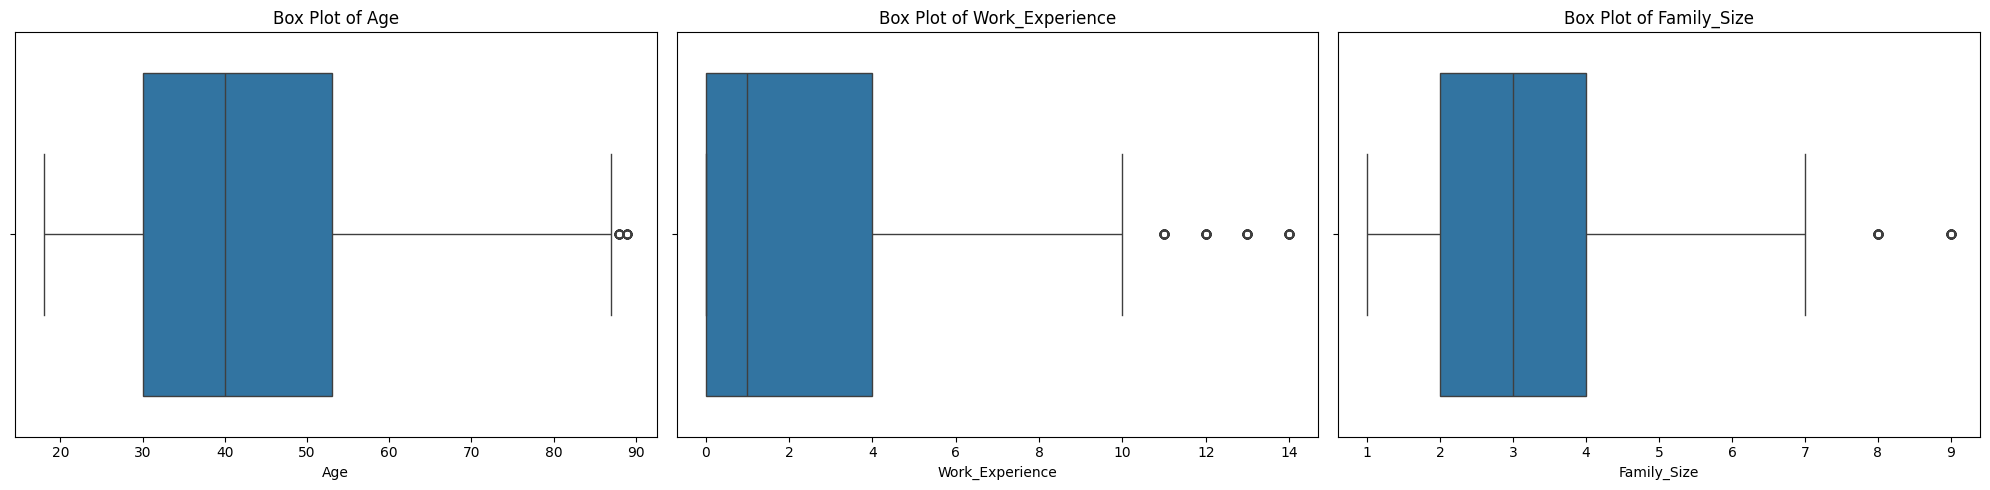

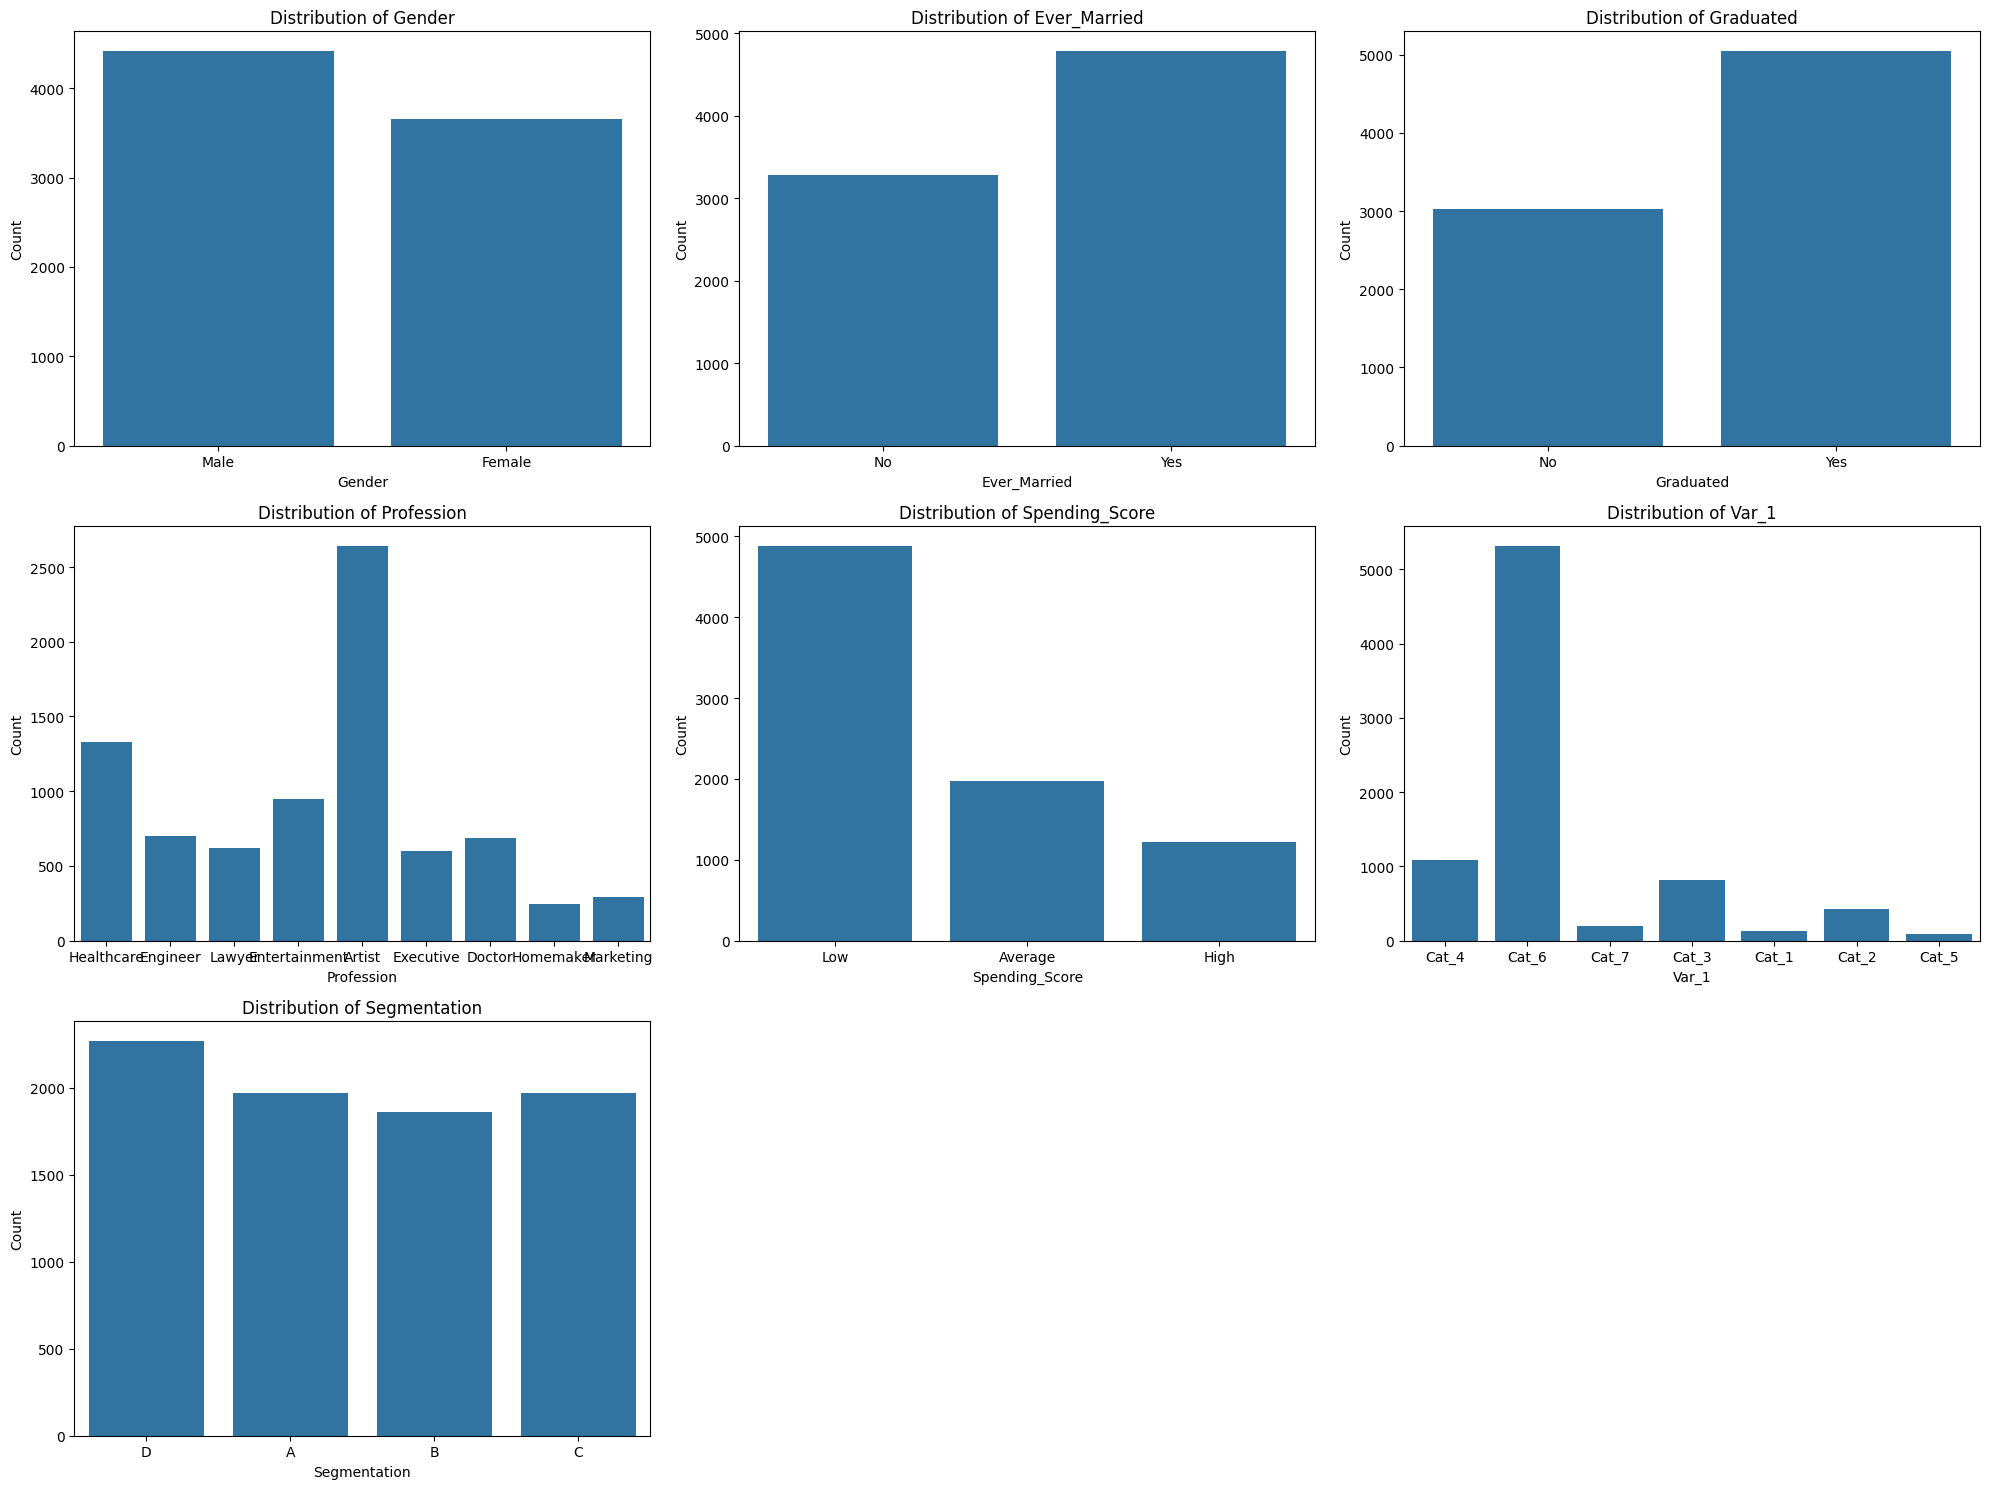

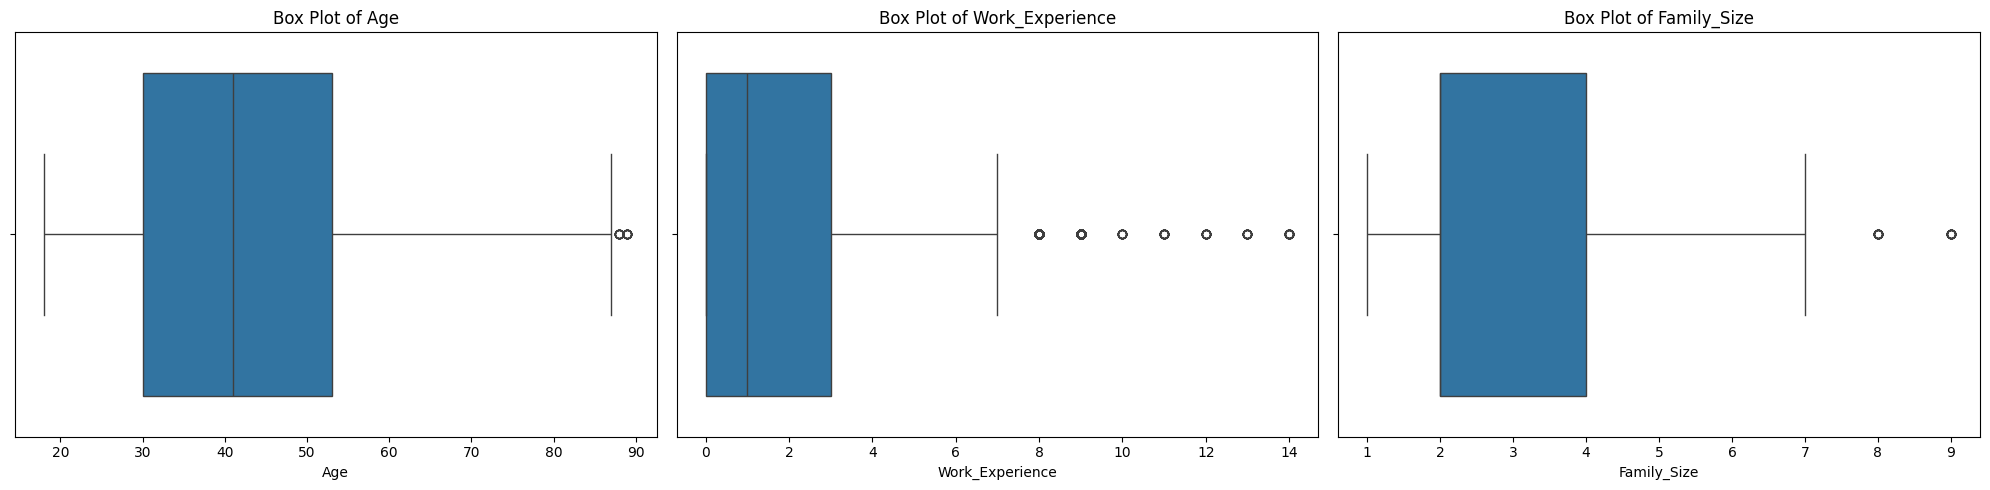

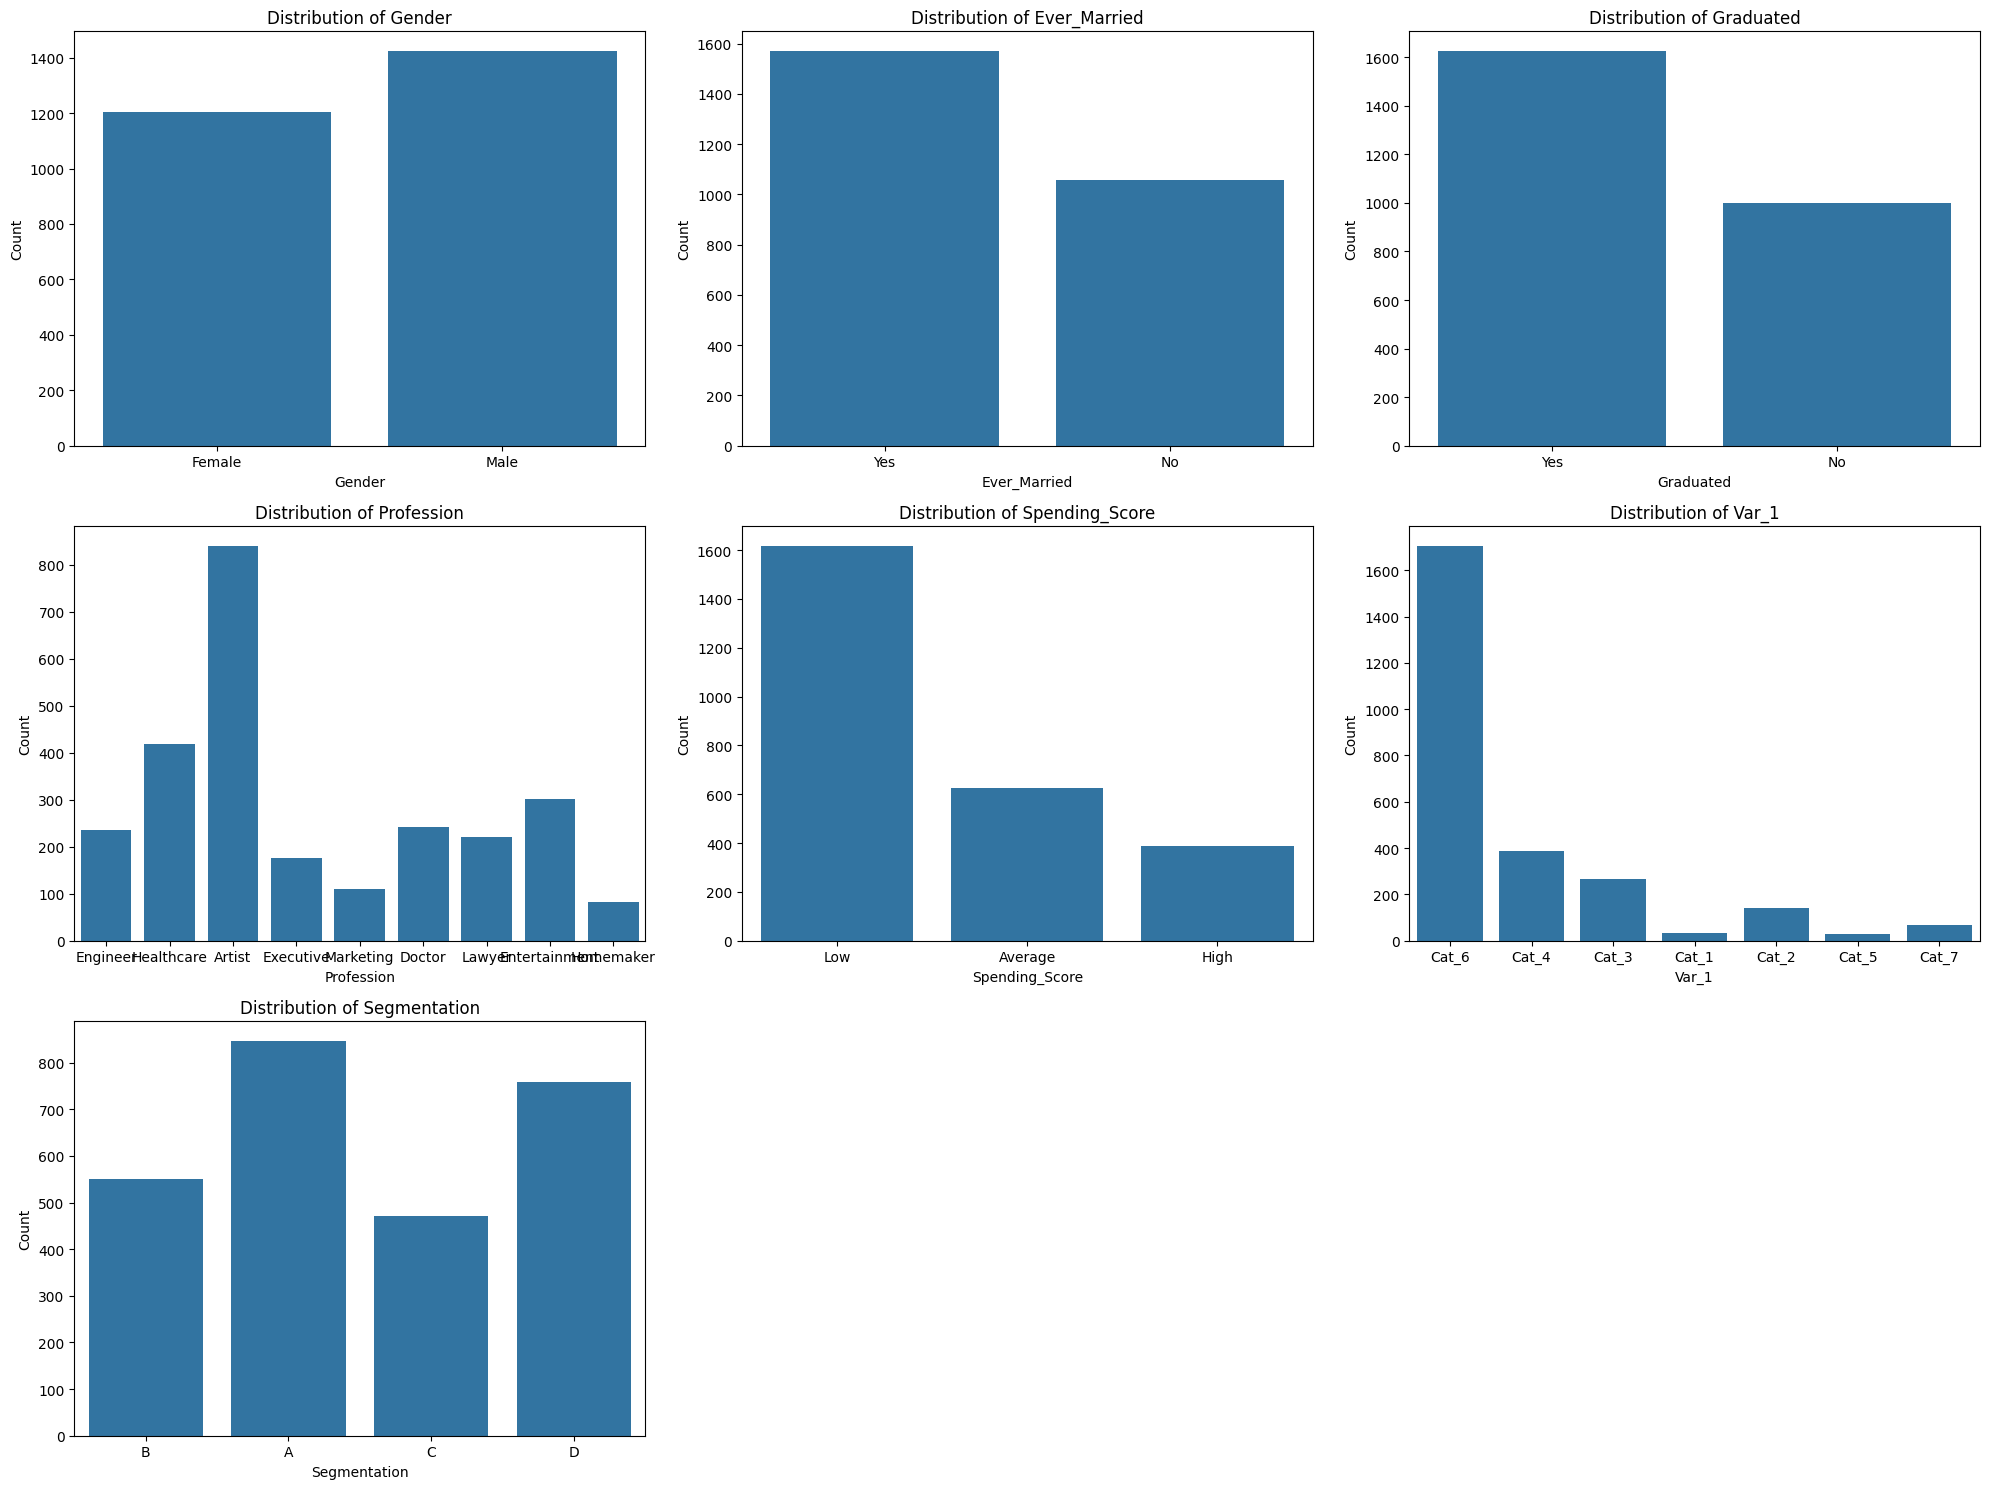

In [ ]:
# Box plots and bar plots for both datasets
datasets_2(df_train)
datasets_2(df_test)

In [ ]:
# Categorical Variable affect in Customer Segments - This helps in understandig the data and how its divided among the 4 customer segments
customersegment1(df_train)
customersegment1(df_test)

In [ ]:
# Profession and Var_1 affect in Customer Segments
customersegment2(df_train)
customersegment2(df_test)

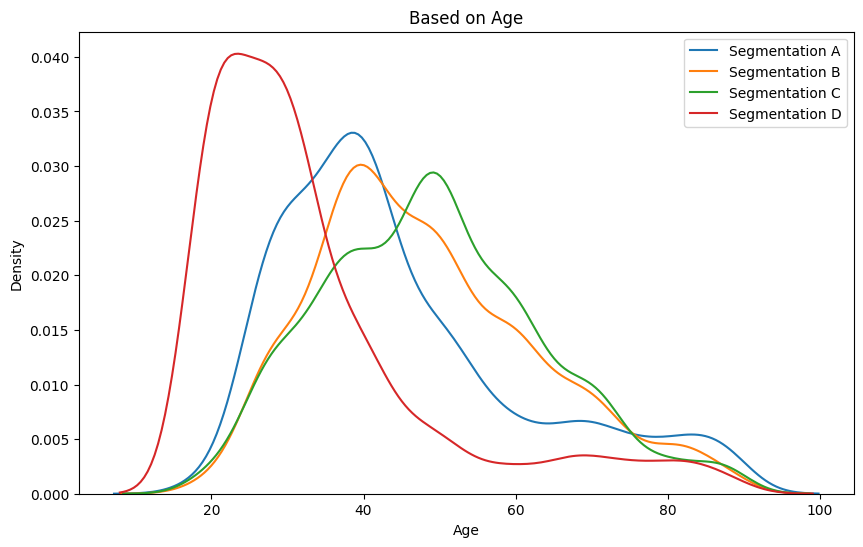

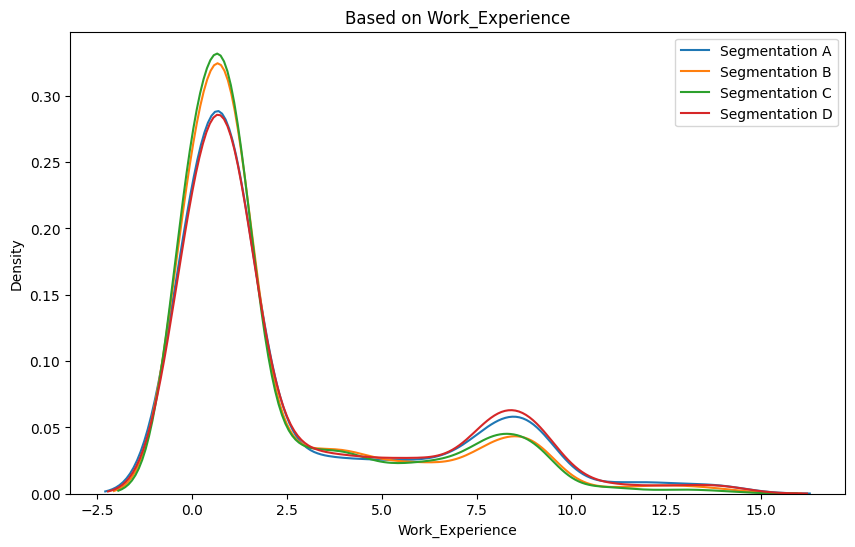

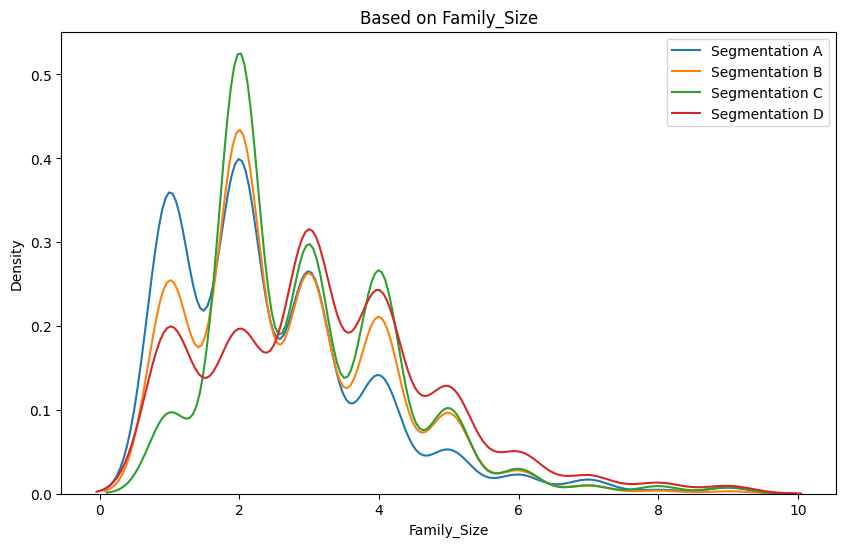

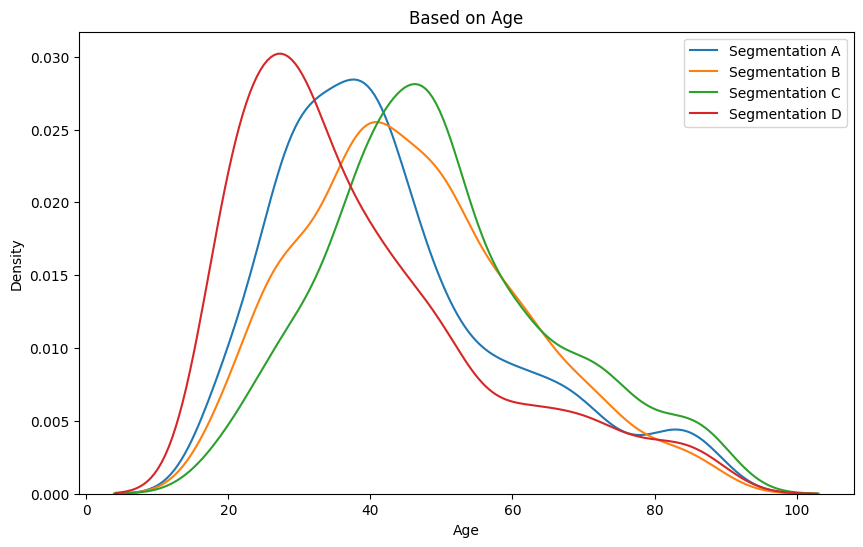

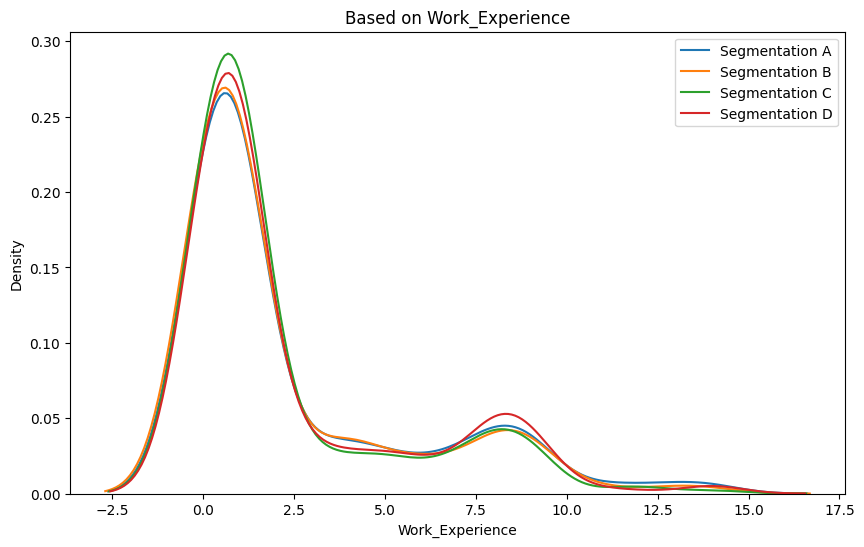

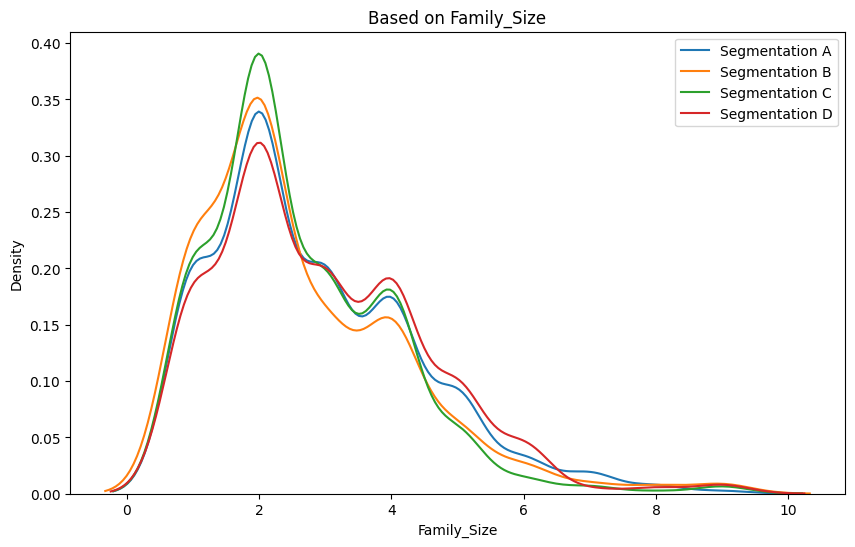

In [ ]:
# Numerical Variable affect in Customer Segment
customersegment3(df_train)
customersegment3(df_test)

In [ ]:
# Converting categorical to numeric, One-hot coding for 'Profession', verifying data integrity
df_train = datasets_3(df_train)
df_test = datasets_3(df_test)

After transformation:
       ID  Gender  Ever_Married  Age  Graduated     Profession  \
0  462809       0             0   22          0     Healthcare   
1  462643       1             1   38          1       Engineer   
2  466315       1             1   67          1       Engineer   
3  461735       0             1   67          1         Lawyer   
4  462669       1             1   40          1  Entertainment   

   Work_Experience  Spending_Score  Family_Size  Var_1  Segmentation  
0              1.0               1          4.0      3             3  
1              1.0               2          3.0      3             0  
2              1.0               1          1.0      5             1  
3              0.0               3          2.0      5             1  
4              1.0               3          6.0      5             0  

Data types of each column:
ID                   int64
Gender               int64
Ever_Married         int64
Age                  int64
Graduated          

In [ ]:
# Data validation
display_data_info(df_train)
display_data_info(df_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        8068 non-null   int64  
 1   Gender                    8068 non-null   int64  
 2   Ever_Married              8068 non-null   int64  
 3   Age                       8068 non-null   int64  
 4   Graduated                 8068 non-null   int64  
 5   Work_Experience           8068 non-null   float64
 6   Spending_Score            8068 non-null   int64  
 7   Family_Size               8068 non-null   float64
 8   Var_1                     8068 non-null   int8   
 9   Segmentation              8068 non-null   int8   
 10  Profession_Artist         8068 non-null   int64  
 11  Profession_Doctor         8068 non-null   int64  
 12  Profession_Engineer       8068 non-null   int64  
 13  Profession_Entertainment  8068 non-null   int64  
 14  Professi

In [ ]:
# Handling outliers, Train
df_train, outliers_info = handle_outliers_iqr(df_train)
print("Number of outliers detected and removed per column:")
print(outliers_info)

Number of outliers detected and removed per column:
{'Age': 71, 'Work_Experience': 188, 'Family_Size': 89}


In [ ]:
display_data_info(df_train)

<class 'pandas.core.frame.DataFrame'>
Index: 7720 entries, 0 to 8067
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        7720 non-null   int64  
 1   Gender                    7720 non-null   int64  
 2   Ever_Married              7720 non-null   int64  
 3   Age                       7720 non-null   int64  
 4   Graduated                 7720 non-null   int64  
 5   Work_Experience           7720 non-null   float64
 6   Spending_Score            7720 non-null   int64  
 7   Family_Size               7720 non-null   float64
 8   Var_1                     7720 non-null   int8   
 9   Segmentation              7720 non-null   int8   
 10  Profession_Artist         7720 non-null   int64  
 11  Profession_Doctor         7720 non-null   int64  
 12  Profession_Engineer       7720 non-null   int64  
 13  Profession_Entertainment  7720 non-null   int64  
 14  Profession_Ex

In [ ]:
# Handling outliers, Test
df_test, outliers_info = handle_outliers_iqr(df_test)
print("Number of outliers detected and removed per column:")
print(outliers_info)

Number of outliers detected and removed per column:
{'Age': 19, 'Work_Experience': 357, 'Family_Size': 26}


In [ ]:
display_data_info(df_test)

<class 'pandas.core.frame.DataFrame'>
Index: 2225 entries, 0 to 2625
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        2225 non-null   int64  
 1   Gender                    2225 non-null   int64  
 2   Ever_Married              2225 non-null   int64  
 3   Age                       2225 non-null   int64  
 4   Graduated                 2225 non-null   int64  
 5   Work_Experience           2225 non-null   float64
 6   Spending_Score            2225 non-null   int64  
 7   Family_Size               2225 non-null   float64
 8   Var_1                     2225 non-null   int8   
 9   Segmentation              2225 non-null   int8   
 10  Profession_Artist         2225 non-null   int64  
 11  Profession_Doctor         2225 non-null   int64  
 12  Profession_Engineer       2225 non-null   int64  
 13  Profession_Entertainment  2225 non-null   int64  
 14  Profession_Ex

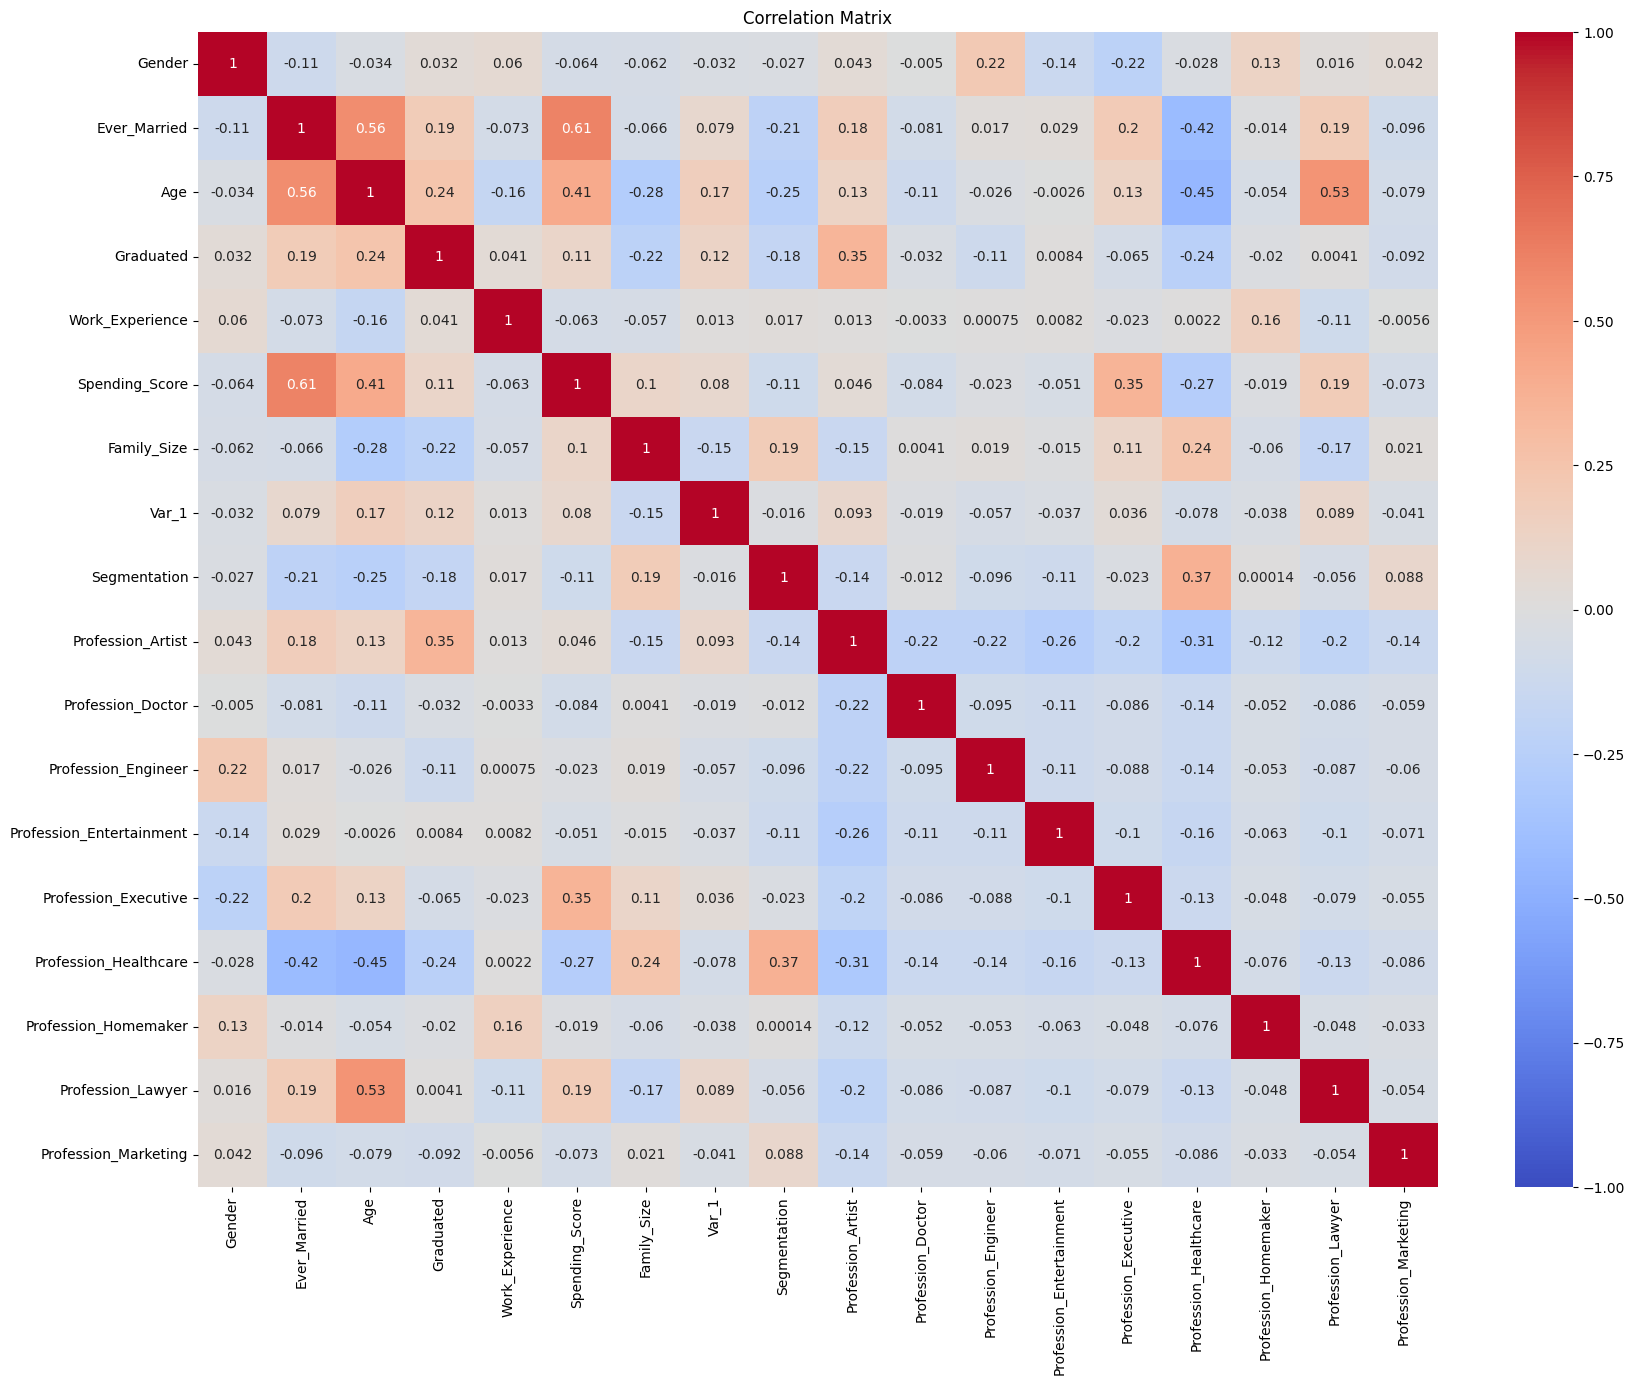

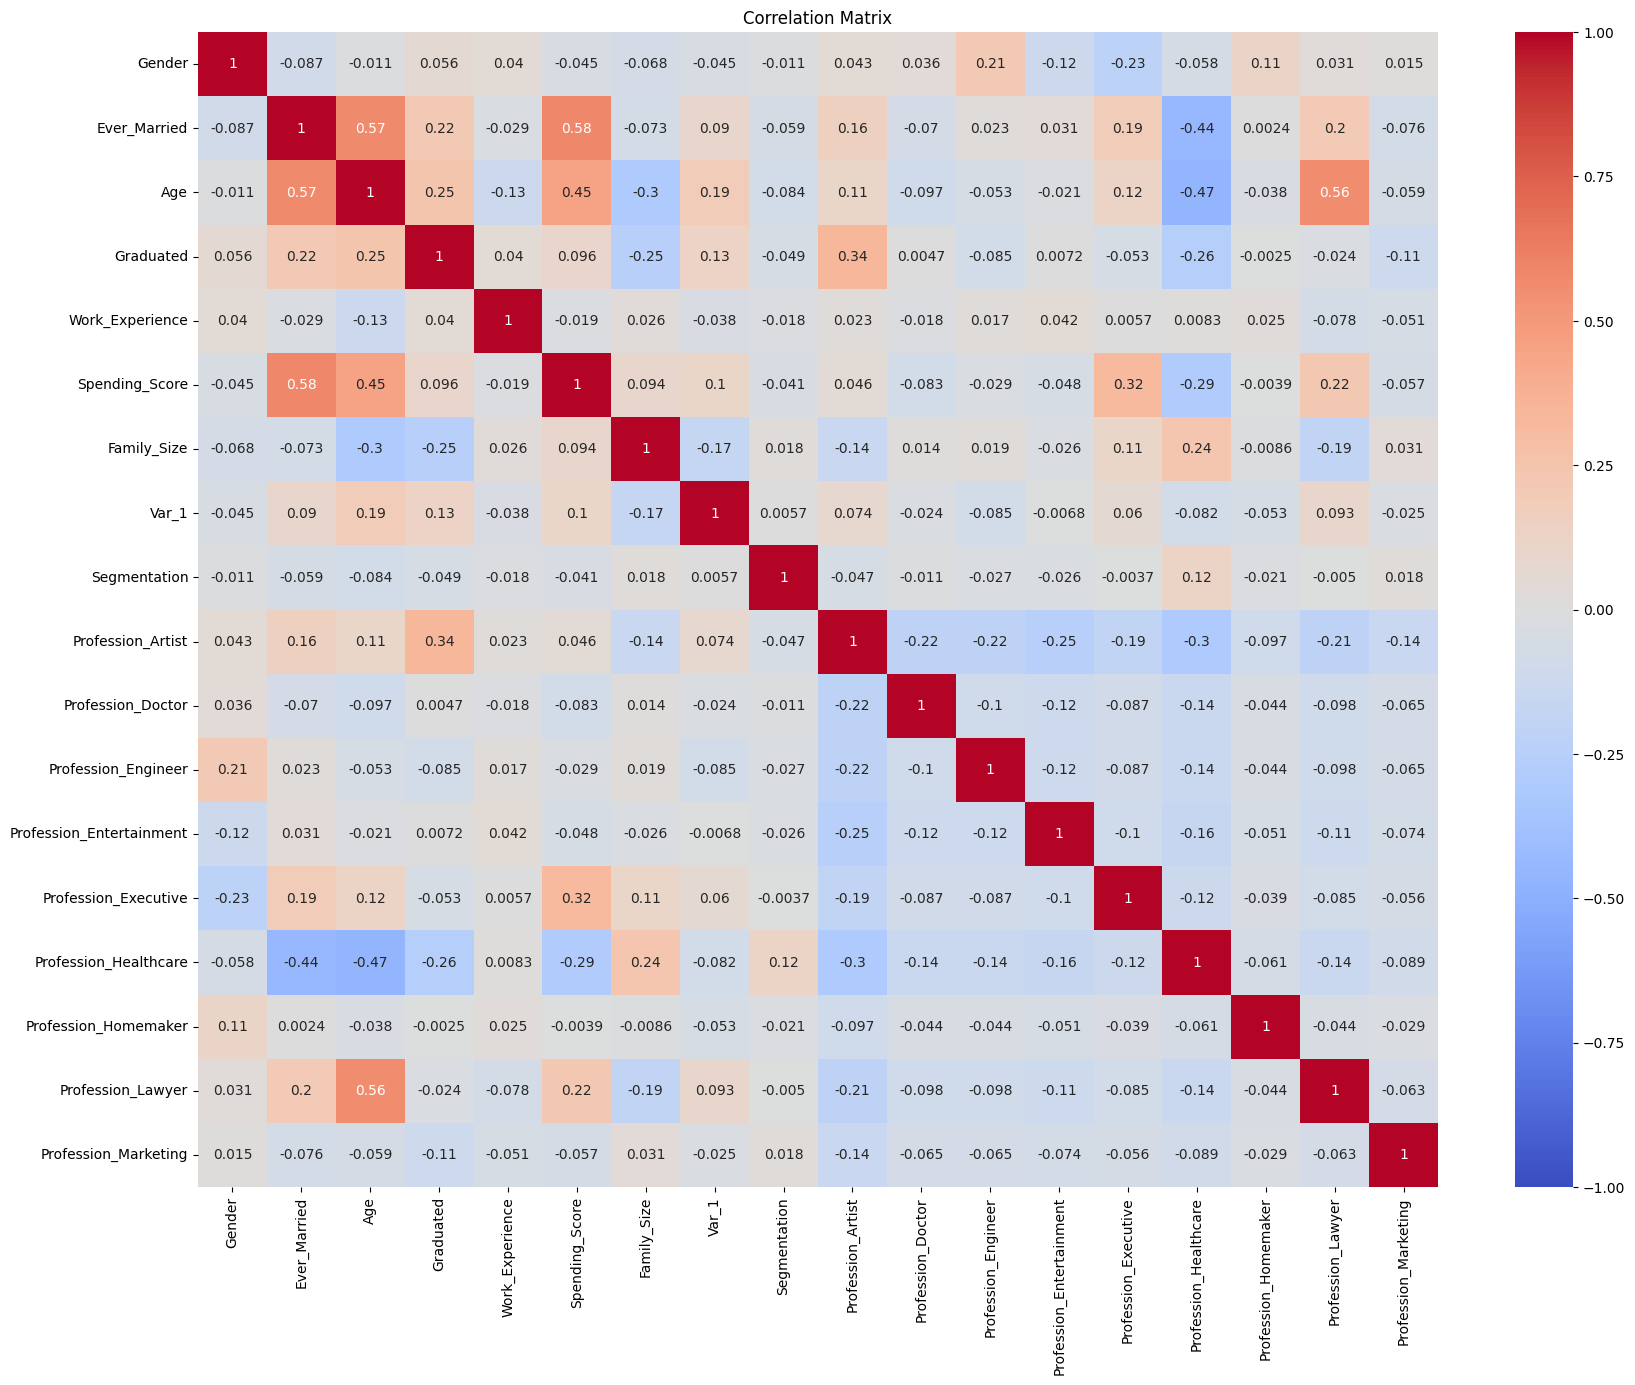

In [ ]:
# Correlation matrix heatmap
df_Matrix_train = df_train.copy()
df_Matrix_test = df_test.copy()

# Removing 'ID' column from the copied dataframes
if 'ID' in df_Matrix_train.columns:
    df_Matrix_train = df_Matrix_train.drop(columns=['ID'])
if 'ID' in df_Matrix_test.columns:
    df_Matrix_test = df_Matrix_test.drop(columns=['ID'])

# Running the analyses function on the copied dataframes
analyses(df_Matrix_train)
analyses(df_Matrix_test)

Detecting Multicollinearity


In [ ]:
# ANOVA and Multicollinearity by computing VIFs
multicollinearity(df_train)

ANOVA Analysis Results:

ANOVA for Gender:
                 sum_sq      df         F    PR(>F)
C(Gender)     7.416202     1.0  5.766357  0.016359
Residual   9926.239757  7718.0       NaN       NaN

ANOVA for Ever_Married:
                       sum_sq      df           F        PR(>F)
C(Ever_Married)   456.057989     1.0  371.386882  7.255299e-81
Residual         9477.597969  7718.0         NaN           NaN

ANOVA for Graduated:
                    sum_sq      df          F        PR(>F)
C(Graduated)   311.197005     1.0  249.60548  2.319253e-55
Residual      9622.458953  7718.0        NaN           NaN

ANOVA for Spending_Score:
                         sum_sq      df          F        PR(>F)
C(Spending_Score)   130.148838     2.0  51.224453  7.941050e-23
Residual           9803.507121  7717.0        NaN           NaN

ANOVA for Var_1:
                sum_sq      df         F    PR(>F)
C(Var_1)    10.086057     6.0  1.306549  0.250264
Residual  9923.569902  7713.0       NaN       NaN

In [ ]:
# ANOVA and Multicollinearity by computing VIFs
multicollinearity(df_test)

ANOVA Analysis Results:

ANOVA for Gender:
                 sum_sq      df         F    PR(>F)
C(Gender)     0.428425     1.0  0.293424  0.588089
Residual   3245.776519  2223.0       NaN       NaN

ANOVA for Ever_Married:
                       sum_sq      df         F   PR(>F)
C(Ever_Married)    11.261876     1.0  7.738977  0.00545
Residual         3234.943068  2223.0       NaN      NaN

ANOVA for Graduated:
                    sum_sq      df         F  PR(>F)
C(Graduated)     7.711273     1.0  5.293251  0.0215
Residual      3238.493671  2223.0       NaN     NaN

ANOVA for Spending_Score:
                         sum_sq      df       F    PR(>F)
C(Spending_Score)     6.018405     2.0  2.0636  0.127239
Residual           3240.186539  2222.0     NaN       NaN

ANOVA for Var_1:
                sum_sq      df         F    PR(>F)
C(Var_1)     5.856248     6.0  0.668095  0.675518
Residual  3240.348696  2218.0       NaN       NaN

ANOVA for Profession_Artist:
                            sum_

In [ ]:
# Identifying the smallest profession group
profession_columns = [col for col in df_train.columns if col.startswith('Profession_')]
smallest_group = df_train[profession_columns].sum().idxmin()
print(f'Smallest profession group: {smallest_group}')

# Removing the smallest profession group from both training and testing datasets
df_train = df_train.drop(columns=[smallest_group])
df_test = df_test.drop(columns=[smallest_group])

print(f"Dropped column: {smallest_group}")

# Recalculate VIF
calculate_vif(df_train.drop(columns=['Segmentation']))

Smallest profession group: Profession_Homemaker
Dropped column: Profession_Homemaker
Variance Inflation Factor (VIF):
                     Feature        VIF
0                         ID  68.140857
1                     Gender   2.122950
2               Ever_Married   5.233403
3                        Age  20.081473
4                  Graduated   3.356086
5            Work_Experience   1.709699
6             Spending_Score  10.094471
7                Family_Size   6.469462
8                      Var_1   9.938055
9          Profession_Artist  13.305704
10         Profession_Doctor   4.148630
11       Profession_Engineer   4.162978
12  Profession_Entertainment   5.441457
13      Profession_Executive   4.096951
14     Profession_Healthcare   7.500802
15         Profession_Lawyer   4.352275
16      Profession_Marketing   2.325514


In [ ]:
# VIF >= 10 as cutoff for multicollinearirty?
# Thus, due to high VIF, we will remove 'Age' from the datasets
df_train = df_train.drop(columns=['Age'])
df_test = df_test.drop(columns=['Age'])

print("Dropped column: Age")

# Recalculating VIF
calculate_vif(df_train.drop(columns=['Segmentation']))

Dropped column: Age
Variance Inflation Factor (VIF):
                     Feature        VIF
0                         ID  58.072770
1                     Gender   2.122515
2               Ever_Married   4.677375
3                  Graduated   3.302065
4            Work_Experience   1.668080
5             Spending_Score  10.050566
6                Family_Size   6.262499
7                      Var_1   9.874526
8          Profession_Artist  13.254904
9          Profession_Doctor   4.148290
10       Profession_Engineer   4.156636
11  Profession_Entertainment   5.429132
12      Profession_Executive   4.056590
13     Profession_Healthcare   7.452532
14         Profession_Lawyer   3.809311
15      Profession_Marketing   2.325289


In [ ]:
# Removing 'ID' Column from both datasets
df_train = remove_id(df_train)
df_test = remove_id(df_test)

In [ ]:
# Recalculating VIF
calculate_vif(df_train.drop(columns=['Segmentation']))

Variance Inflation Factor (VIF):
                     Feature       VIF
0                     Gender  2.002801
1               Ever_Married  4.659409
2                  Graduated  3.238803
3            Work_Experience  1.582924
4             Spending_Score  9.791320
5                Family_Size  5.811284
6                      Var_1  8.562063
7          Profession_Artist  6.121046
8          Profession_Doctor  2.106549
9        Profession_Engineer  2.223826
10  Profession_Entertainment  2.556815
11      Profession_Executive  2.537981
12     Profession_Healthcare  3.336578
13         Profession_Lawyer  2.211788
14      Profession_Marketing  1.440894


At this point, both datasets have been preprocessed and are ready for classification models!

# Part 2 - Preparing Datasets for Modeling

Defining Train and Test

In [ ]:
# Defining train and target for modeling, with tarin transformed dataset (df_train) as training, test transformed dataset (df_test) as test
X_train = df_train.drop(columns=['Segmentation'])
y_train = df_train['Segmentation']

X_test = df_test.drop(columns=['Segmentation'])
y_test = df_test['Segmentation']


Functions for Confusion Matrices and Learning Curves

In [ ]:
# For modeling - Functions for confusion matrices, learning curves
def plot_confusion_matrix(cm, title, save_path=None):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    if save_path:
        plt.savefig(save_path)
    plt.show()

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    # Calculating learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)

    # Calculating mean and standard deviation for training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plotting learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")

    plt.show()
    # return plt

Feature Selection by Ridge and Lasso Regression

Lasso Regression MSE: 1.4864184294084097
Lasso Regression R^2: -0.018814604336598206
Lasso selected 5 features from 15
Selected features and their coefficients:
Ever_Married            -0.007076
Graduated               -0.015666
Family_Size              0.041836
Profession_Healthcare    0.304792
Profession_Marketing     0.023125
dtype: float64


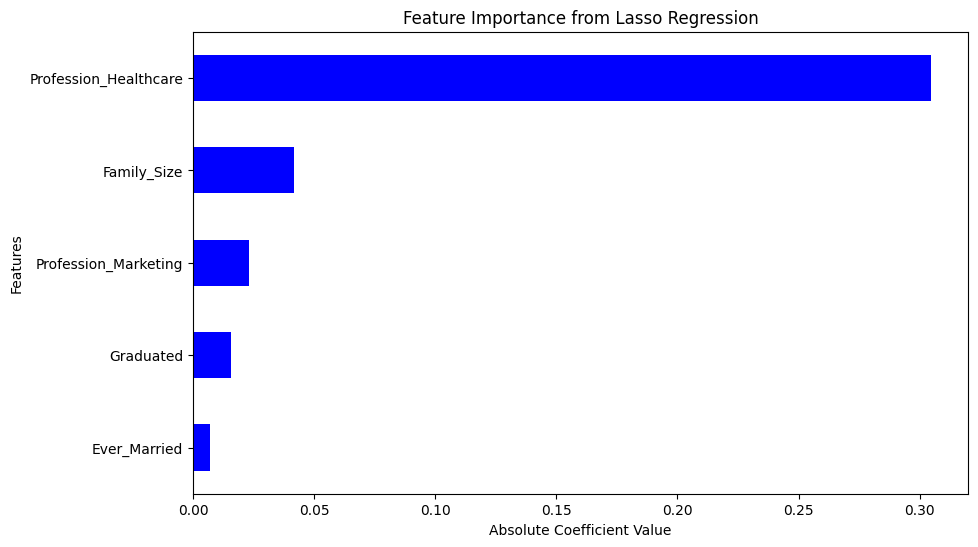

Lasso Regression CV MSE: 1.1065994879859478


In [ ]:
# Lasso Regression for feature selection

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
lasso_pred = lasso.predict(X_test_scaled)
lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_r2 = r2_score(y_test, lasso_pred)
print(f"Lasso Regression MSE: {lasso_mse}")
print(f"Lasso Regression R^2: {lasso_r2}")

# Feature Importance from Lasso Regression
lasso_coefficients = pd.Series(lasso.coef_, index=X_train.columns)
lasso_coefficients = lasso_coefficients[lasso_coefficients != 0]
print(f"Lasso selected {len(lasso_coefficients)} features from {X_train.shape[1]}")
print("Selected features and their coefficients:")
print(lasso_coefficients)

# Plotting Lasso Feature Importance (absolute values to avoid negative importance)
plt.figure(figsize=(10, 6))
lasso_coefficients.abs().sort_values().plot(kind='barh', color='blue')
plt.title('Feature Importance from Lasso Regression')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Features')
plt.show()

# Further Evaluation with Cross-Validation
lasso_cv_scores = cross_val_score(lasso, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Lasso Regression CV MSE: {-np.mean(lasso_cv_scores)}")

# Part 3 - Classification models
PCA Dimensionality Reduction

Classifiers and Hyperparameter tuning

Ensemble Models

SVM

Class Imbalance

Feature Importance

Learning Curves

Evaluating all models

Pipeline with PCA and DecisionTree Classifier

Decision Tree Accuracy: 0.3042696629213483
Confusion Matrix:
[[196 163 179 177]
 [140 117 114  96]
 [118  95 141  54]
 [162 110 140 223]]
Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.27      0.29       715
           1       0.24      0.25      0.25       467
           2       0.25      0.35      0.29       408
           3       0.41      0.35      0.38       635

    accuracy                           0.30      2225
   macro avg       0.30      0.31      0.30      2225
weighted avg       0.31      0.30      0.31      2225



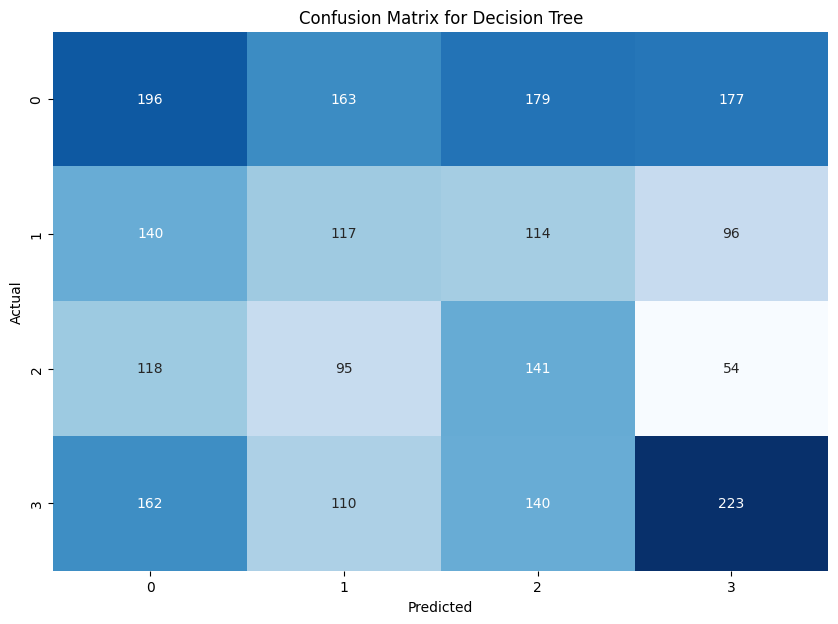

In [ ]:
# Creating a pipeline with PCA for dimensionality reduction, DecisionTree Classifer
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # Retain 95% of the variance
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Training and evaluating the pipeline
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred)}")
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
plot_confusion_matrix(cm, "Confusion Matrix for Decision Tree")

GridSearchCV Hyperparameter Tuning

Best Parameters: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2}
Best Cross-validation Accuracy: 0.48717616580310874
Confusion Matrix:
[[232 111 178 194]
 [158  74 138  97]
 [119  73 153  63]
 [164  93 118 260]]

Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.32      0.33       715
           1       0.21      0.16      0.18       467
           2       0.26      0.38      0.31       408
           3       0.42      0.41      0.42       635

    accuracy                           0.32      2225
   macro avg       0.31      0.32      0.31      2225
weighted avg       0.32      0.32      0.32      2225



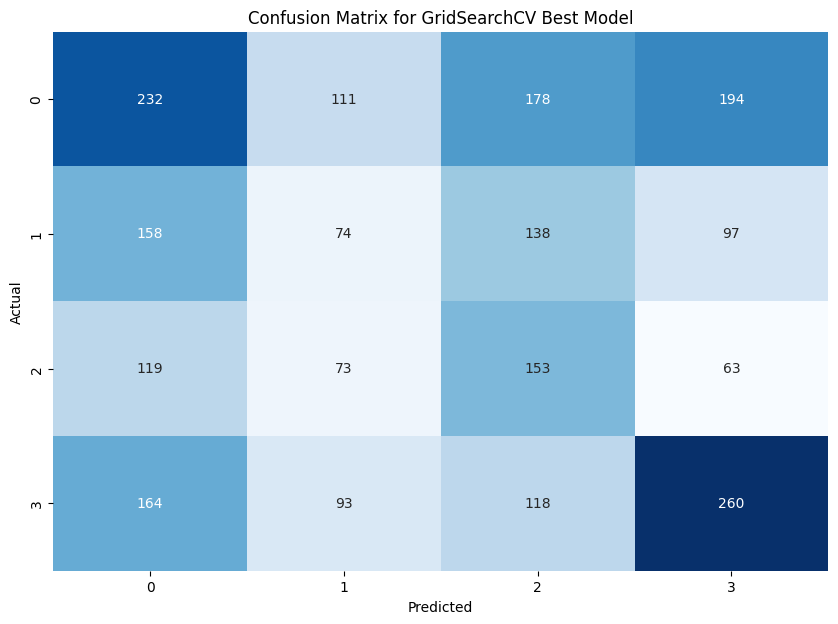

In [ ]:
# Hyperparameters tuning with GridSearchCV
# Defining the parameter grid
param_grid = {
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10]
}

# Creating the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fitting the model and finding the best parameters
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-validation Accuracy: {best_score}")

# Evaluating on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
plot_confusion_matrix(cm, "Confusion Matrix for GridSearchCV Best Model")

RandomizedSearchCV Hyperparameter Tuning

Best Parameters: {'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 5}
Best Cross-validation Accuracy: 0.48730569948186525
Confusion Matrix:
[[232 111 178 194]
 [158  74 138  97]
 [119  73 153  63]
 [164  93 118 260]]

Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.32      0.33       715
           1       0.21      0.16      0.18       467
           2       0.26      0.38      0.31       408
           3       0.42      0.41      0.42       635

    accuracy                           0.32      2225
   macro avg       0.31      0.32      0.31      2225
weighted avg       0.32      0.32      0.32      2225



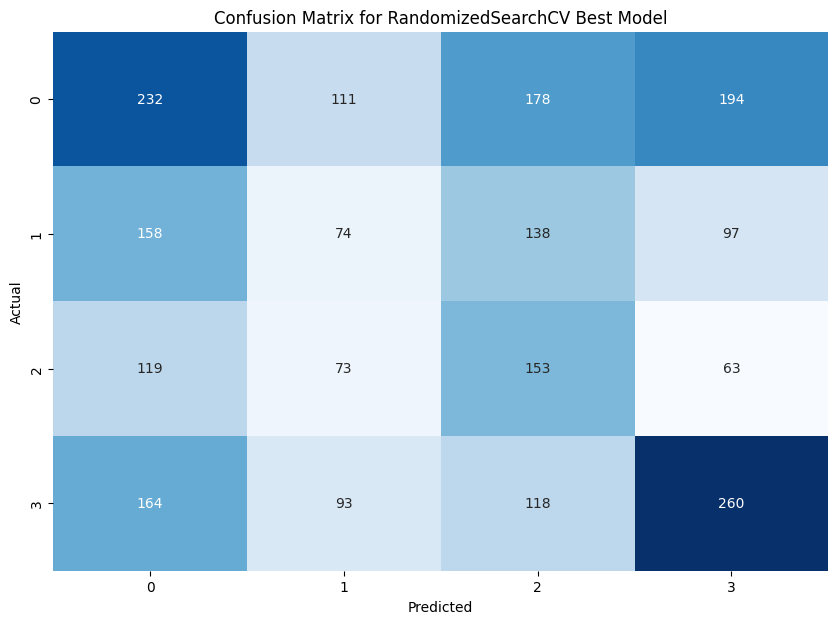

In [ ]:
# Hyperparameters tuning with RandomizedSearchCV
# Defining the parameter grid
param_dist = {
    'classifier__max_depth': [5, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10, 15],
    'classifier__min_samples_leaf': [1, 2, 5, 10]
}
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=50, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

# Best parameters
best_params = random_search.best_params_
best_score = random_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-validation Accuracy: {best_score}")

# Evaluating on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
plot_confusion_matrix(cm, "Confusion Matrix for RandomizedSearchCV Best Model")

Ensemble Models

Model: AdaBoost
Accuracy: 0.31820224719101126
Confusion Matrix:
[[203 115 193 204]
 [130  93 133 111]
 [101 102 140  65]
 [144  73 146 272]]

Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.28      0.31       715
           1       0.24      0.20      0.22       467
           2       0.23      0.34      0.27       408
           3       0.42      0.43      0.42       635

    accuracy                           0.32      2225
   macro avg       0.31      0.31      0.31      2225
weighted avg       0.32      0.32      0.32      2225





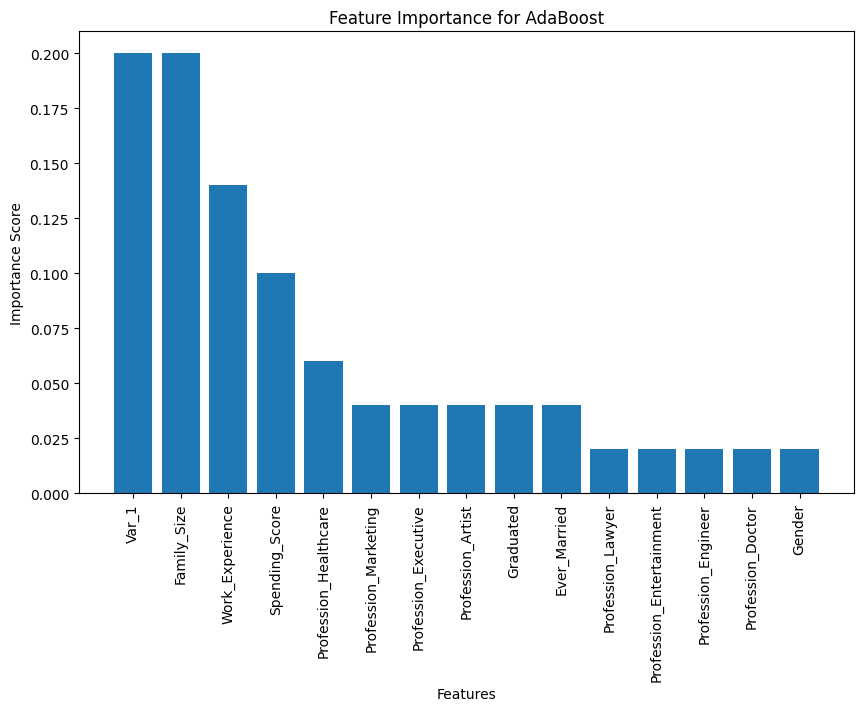

Feature importances:
Var_1: 0.2000
Family_Size: 0.2000
Work_Experience: 0.1400
Spending_Score: 0.1000
Profession_Healthcare: 0.0600
Profession_Marketing: 0.0400
Profession_Executive: 0.0400
Profession_Artist: 0.0400
Graduated: 0.0400
Ever_Married: 0.0400
Profession_Lawyer: 0.0200
Profession_Entertainment: 0.0200
Profession_Engineer: 0.0200
Profession_Doctor: 0.0200
Gender: 0.0200
Model: Gradient Boosted Trees
Accuracy: 0.31775280898876407
Confusion Matrix:
[[173 159 171 212]
 [112 114 128 113]
 [101  95 150  62]
 [123 110 132 270]]

Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.24      0.28       715
           1       0.24      0.24      0.24       467
           2       0.26      0.37      0.30       408
           3       0.41      0.43      0.42       635

    accuracy                           0.32      2225
   macro avg       0.31      0.32      0.31      2225
weighted avg       0.32      0.32      0.32      2225





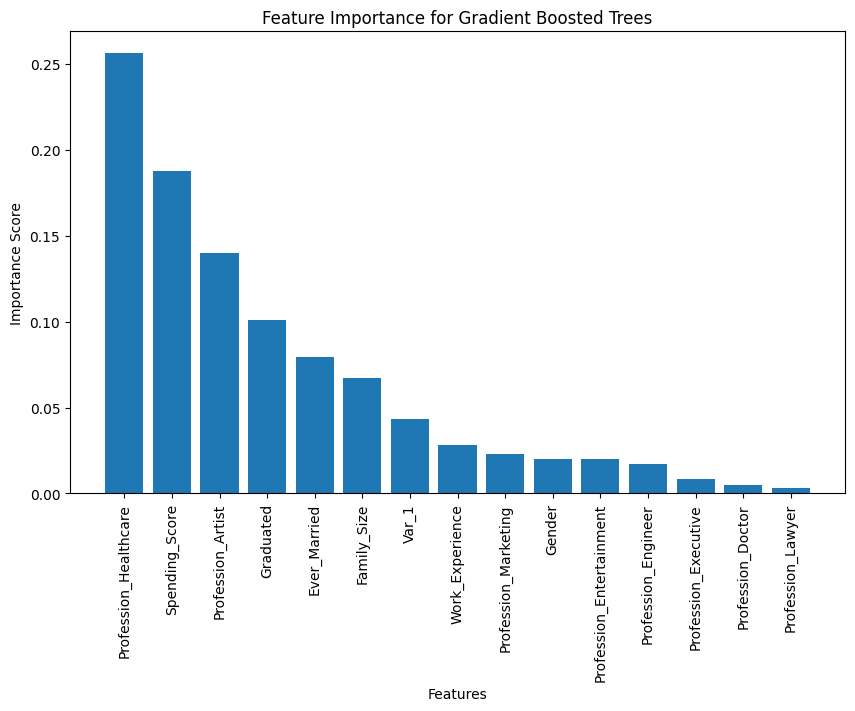

Feature importances:
Profession_Healthcare: 0.2561
Spending_Score: 0.1879
Profession_Artist: 0.1400
Graduated: 0.1011
Ever_Married: 0.0792
Family_Size: 0.0671
Var_1: 0.0435
Work_Experience: 0.0281
Profession_Marketing: 0.0230
Gender: 0.0199
Profession_Entertainment: 0.0198
Profession_Engineer: 0.0173
Profession_Executive: 0.0087
Profession_Doctor: 0.0049
Profession_Lawyer: 0.0034
Model: Random Forest
Accuracy: 0.30382022471910114
Confusion Matrix:
[[170 154 188 203]
 [114 111 119 123]
 [ 91  93 152  72]
 [140 109 143 243]]

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.24      0.28       715
           1       0.24      0.24      0.24       467
           2       0.25      0.37      0.30       408
           3       0.38      0.38      0.38       635

    accuracy                           0.30      2225
   macro avg       0.30      0.31      0.30      2225
weighted avg       0.31      0.30      0.30      2225





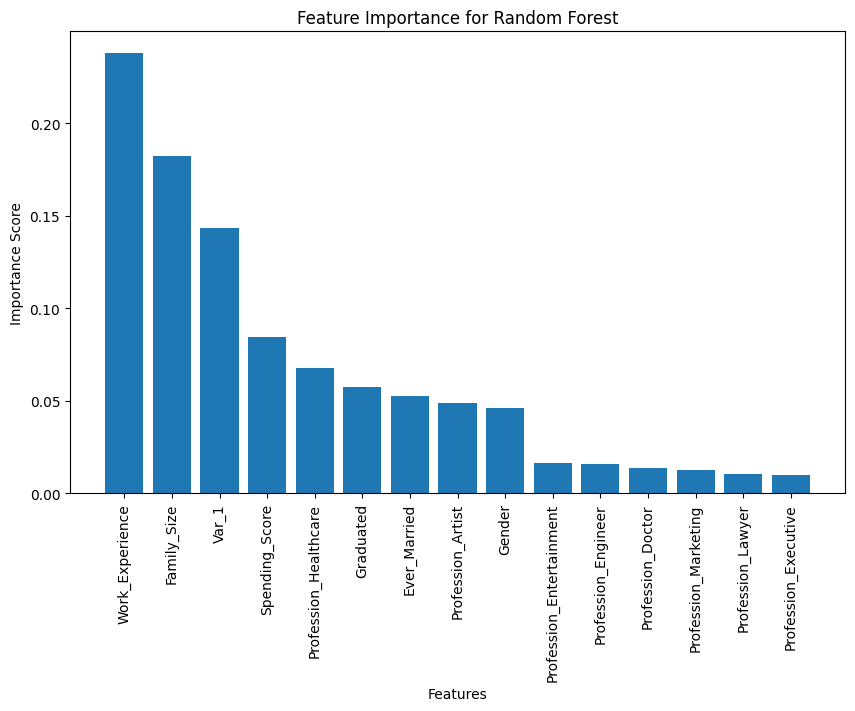

Feature importances:
Work_Experience: 0.2378
Family_Size: 0.1824
Var_1: 0.1438
Spending_Score: 0.0843
Profession_Healthcare: 0.0678
Graduated: 0.0574
Ever_Married: 0.0524
Profession_Artist: 0.0489
Gender: 0.0462
Profession_Entertainment: 0.0167
Profession_Engineer: 0.0158
Profession_Doctor: 0.0140
Profession_Marketing: 0.0124
Profession_Lawyer: 0.0103
Profession_Executive: 0.0098


In [ ]:
# Ensemble models
# Defining the ensemble models
ensemble_models = {
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Gradient Boosted Trees': GradientBoostingClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Training and evaluating models
for model_name, model in ensemble_models.items():
    # No PCA in the pipeline in order to plot feature importance correctly
    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:\n", report)
    print("\n" + "="*60 + "\n")

    # Plotting feature importance for ensemble models
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_

        # Sorting feature importances in descending order
        indices = np.argsort(feature_importances)[::-1]

        # Rearranging feature names so they match the sorted feature importances
        names = [X_train.columns[i] for i in indices]

        plt.figure(figsize=(10, 6))
        plt.title(f"Feature Importance for {model_name}")
        plt.bar(range(X_train.shape[1]), feature_importances[indices])
        plt.xticks(range(X_train.shape[1]), names, rotation=90)
        plt.xlabel('Features')
        plt.ylabel('Importance Score')
        plt.show()

        # Display the importance scores
        print("Feature importances:")
        for name, importance in zip(names, feature_importances[indices]):
            print(f"{name}: {importance:.4f}")

Learning Curves for AdaBoost and Gradient Boosted Trees

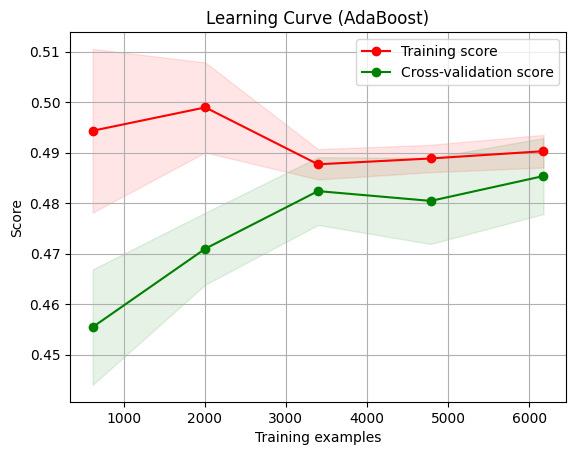

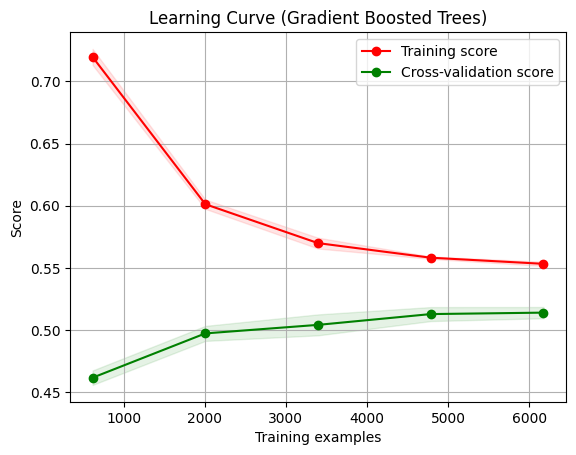

In [ ]:
# Plotting learning curves for AdaBoost and Gradient Boosted Trees
plot_learning_curve(AdaBoostClassifier(random_state=42), "Learning Curve (AdaBoost)", X_train, y_train, cv=5, n_jobs=-1)
plot_learning_curve(GradientBoostingClassifier(random_state=42), "Learning Curve (Gradient Boosted Trees)", X_train, y_train, cv=5, n_jobs=-1)


Support Vector Machine (SVM) Model

In [ ]:
# Defining the SVM model parameters
svm = SVC(kernel='linear', random_state=42, probability=True)

# Creating a pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # Retain 95% of the variance
    ('classifier', svm)
])

# Training and evaluating the SVM model
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Model: Support Vector Machine (SVM)")
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:\n", report)
print("\n" + "="*60 + "\n")

Model: Support Vector Machine (SVM)
Accuracy: 0.3155056179775281
Confusion Matrix:
[[226  98 219 172]
 [155  58 164  90]
 [110  66 181  51]
 [175  61 162 237]]

Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.32      0.33       715
           1       0.20      0.12      0.15       467
           2       0.25      0.44      0.32       408
           3       0.43      0.37      0.40       635

    accuracy                           0.32      2225
   macro avg       0.31      0.31      0.30      2225
weighted avg       0.32      0.32      0.31      2225





Treating Class Imbalance

Confusion Matrix:
[[213 170 165 167]
 [146 119 114  88]
 [121 105 127  55]
 [167 111 136 221]]

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.30      0.31       715
           1       0.24      0.25      0.24       467
           2       0.23      0.31      0.27       408
           3       0.42      0.35      0.38       635

    accuracy                           0.31      2225
   macro avg       0.30      0.30      0.30      2225
weighted avg       0.32      0.31      0.31      2225



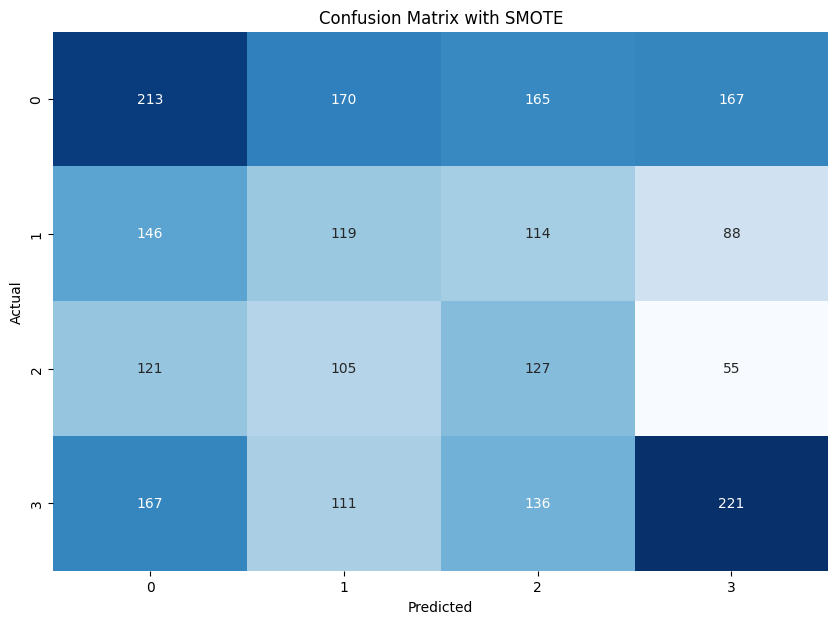

Confusion Matrix with RandomUnderSampler:
[[204 174 185 152]
 [145 119 121  82]
 [119 101 137  51]
 [167 112 145 211]]

Classification Report with RandomUnderSampler:
               precision    recall  f1-score   support

           0       0.32      0.29      0.30       715
           1       0.24      0.25      0.24       467
           2       0.23      0.34      0.28       408
           3       0.43      0.33      0.37       635

    accuracy                           0.30      2225
   macro avg       0.30      0.30      0.30      2225
weighted avg       0.32      0.30      0.31      2225



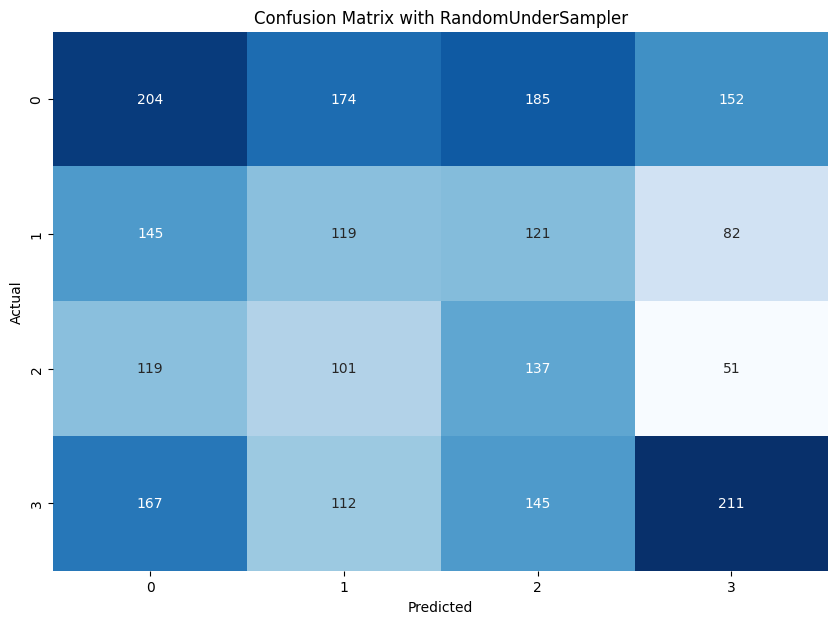

Confusion Matrix with Class Weights:
[[174 188 184 169]
 [135 124 114  94]
 [ 97 116 139  56]
 [143 123 147 222]]

Classification Report with Class Weights:
               precision    recall  f1-score   support

           0       0.32      0.24      0.28       715
           1       0.23      0.27      0.24       467
           2       0.24      0.34      0.28       408
           3       0.41      0.35      0.38       635

    accuracy                           0.30      2225
   macro avg       0.30      0.30      0.29      2225
weighted avg       0.31      0.30      0.30      2225



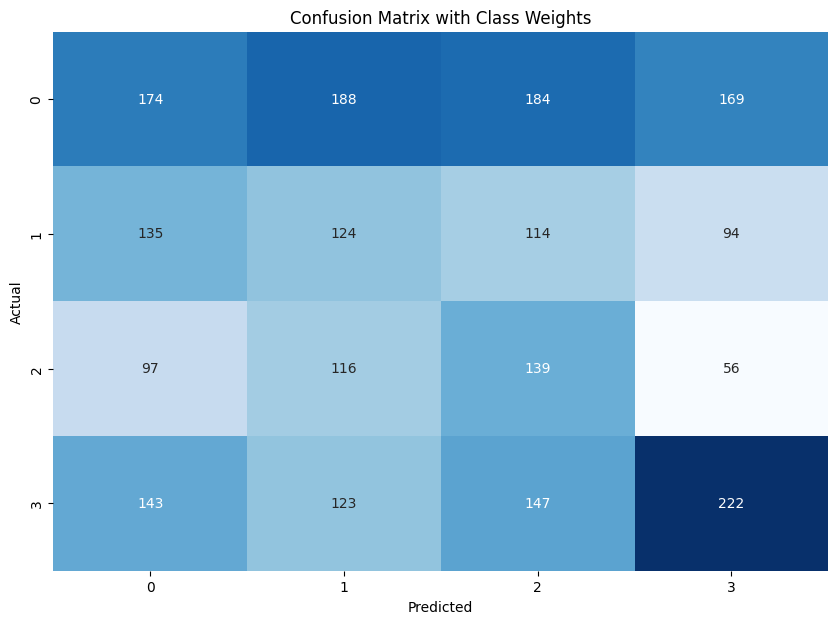

In [ ]:
# Addressing possible class imbalance
# Creating pipeline with SMOTE
pipeline = imPipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # Retain 95% of the variance
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Training the model
pipeline.fit(X_train, y_train)

# Predicting and evaluating
y_pred = pipeline.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred), "Confusion Matrix with SMOTE")


# Creating pipeline with RandomUnderSampler
undersample_pipeline = imPipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # Retain 95% of the variance
    ('undersample', RandomUnderSampler(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Training the model with RandomUnderSampler
undersample_pipeline.fit(X_train, y_train)

# Predicting and evaluating with RandomUnderSampler
y_pred_undersample = undersample_pipeline.predict(X_test)
print("Confusion Matrix with RandomUnderSampler:")
print(confusion_matrix(y_test, y_pred_undersample))
print("\nClassification Report with RandomUnderSampler:\n", classification_report(y_test, y_pred_undersample))
plot_confusion_matrix(confusion_matrix(y_test, y_pred_undersample), "Confusion Matrix with RandomUnderSampler")


# Using class weights in the DecisionTreeClassifier
class_weight_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # Retain 95% of the variance
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

# Training the model with class weights
class_weight_pipeline.fit(X_train, y_train)

# Predicting and evaluating with class weights
y_pred_class_weight = class_weight_pipeline.predict(X_test)
print("Confusion Matrix with Class Weights:")
print(confusion_matrix(y_test, y_pred_class_weight))
print("\nClassification Report with Class Weights:\n", classification_report(y_test, y_pred_class_weight))
plot_confusion_matrix(confusion_matrix(y_test, y_pred_class_weight), "Confusion Matrix with Class Weights")

Feature Importance

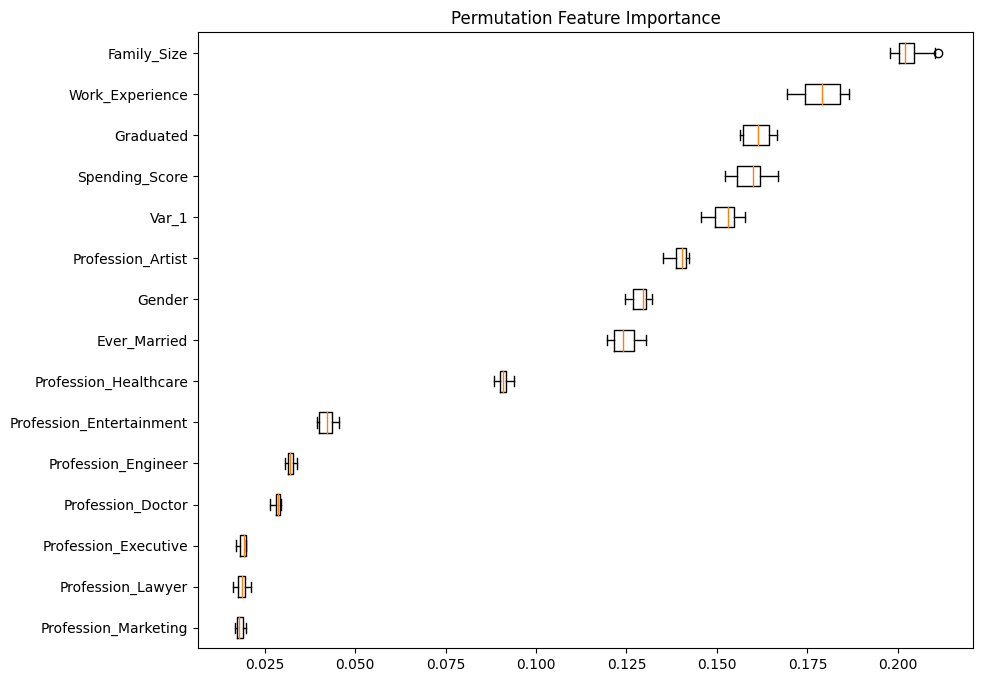

In [ ]:
# Feature Importance with Permutation Importance
# Fitting a model directly on scaled data
rf_original = RandomForestClassifier(random_state=42)
rf_original.fit(X_train_scaled, y_train)  # X_train_scaled is from original features

# Assessing permutation importance
results = permutation_importance(rf_original, X_train_scaled, y_train, n_repeats=10, random_state=42, n_jobs=-1)

# Plotting the results
sorted_idx = results.importances_mean.argsort()
plt.figure(figsize=(10, 8))
plt.boxplot(results.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
plt.title("Permutation Feature Importance")
plt.show()

# Part 4 - Summarizing and Comparing Models

Model: Decision Tree with GridSearchCV
Cross-Validation Accuracy: 0.4925 ± 0.0079
Test Accuracy: 0.3155056179775281
Confusion Matrix:
[[175 206 127 207]
 [122 151  93 101]
 [ 93 143 113  59]
 [143 143  86 263]]

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.24      0.28       715
           1       0.23      0.32      0.27       467
           2       0.27      0.28      0.27       408
           3       0.42      0.41      0.42       635

    accuracy                           0.32      2225
   macro avg       0.31      0.31      0.31      2225
weighted avg       0.32      0.32      0.32      2225



Model: Decision Tree with RandomizedSearchCV
Cross-Validation Accuracy: 0.4925 ± 0.0079
Test Accuracy: 0.3155056179775281
Confusion Matrix:
[[175 206 127 207]
 [122 151  93 101]
 [ 93 143 113  59]
 [143 143  86 263]]

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0

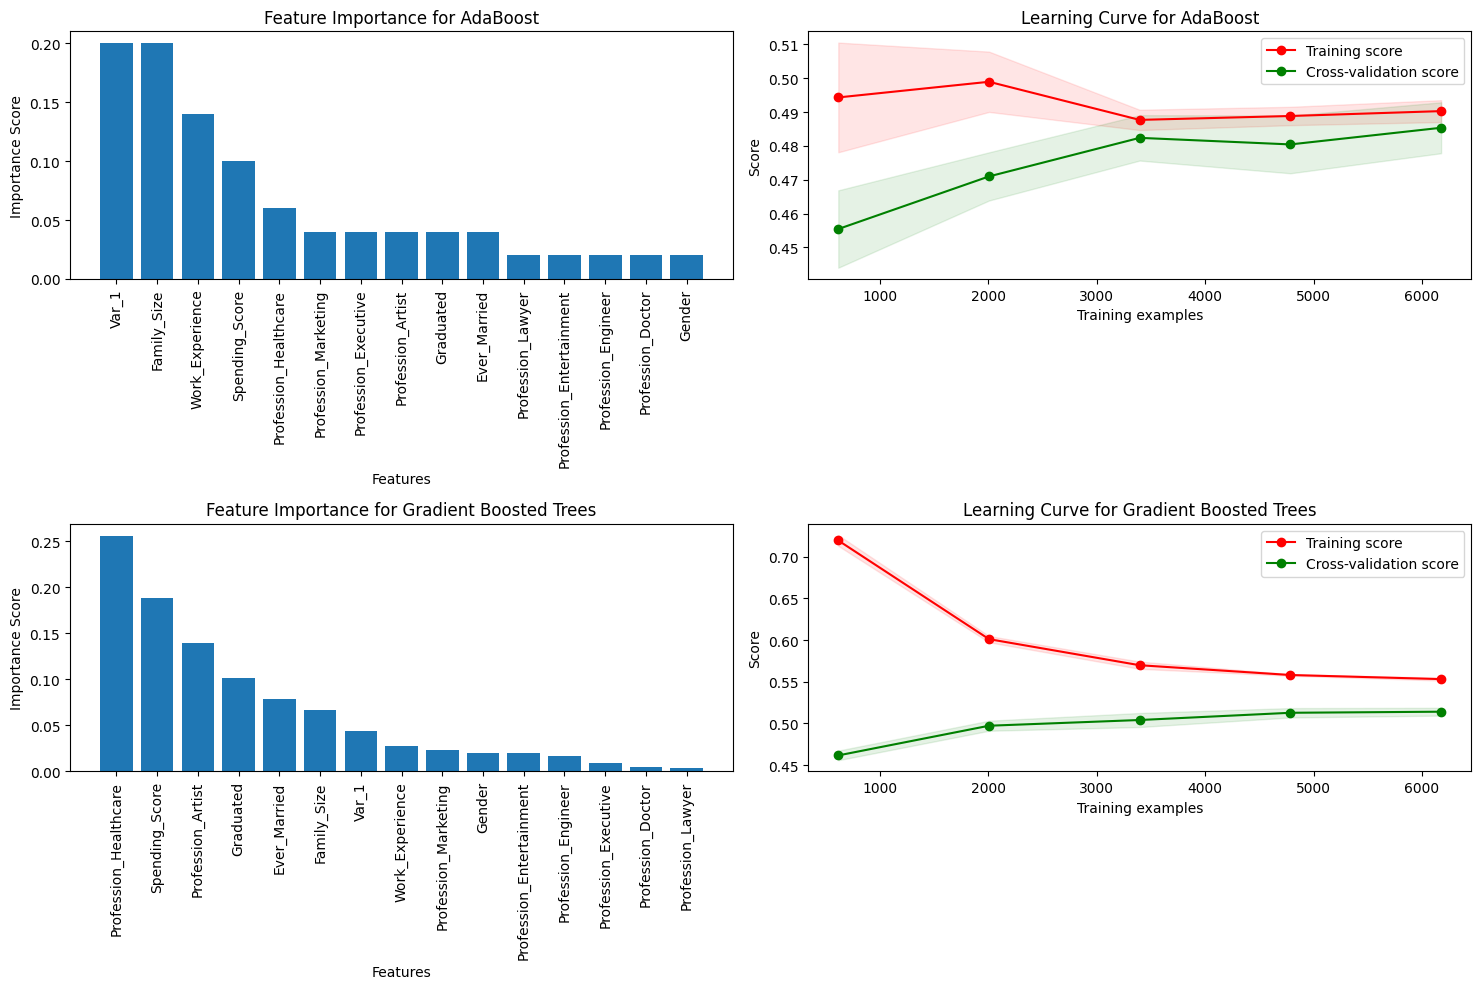

In [ ]:
# Final evaluation of all models with the best parameters and techniques (class imbalance excluded)

# Best parameters found from GridSearchCV and RandomizedSearchCV
best_params_grid_search = {'max_depth': 5, 'min_samples_split': 2}
best_params_random_search = {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2}

# List of final models to be evaluated
final_models = {
    'Decision Tree with GridSearchCV': DecisionTreeClassifier(random_state=42, **best_params_grid_search),
    'Decision Tree with RandomizedSearchCV': DecisionTreeClassifier(random_state=42, **best_params_random_search),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosted Trees': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'SVM': SVC(kernel='linear', random_state=42, probability=True)
}

# Dictionary to store model performance
model_performance = {}

# Evaluate each model
for model_name, model in final_models.items():
    # No PCA in the pipeline for feature importance
    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # Performing cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)

    # Fitting the pipeline on the full training data
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Storing model performance
    model_performance[model_name] = {
        'pipeline': pipeline,
        'cv_score_mean': mean_cv_score,
        'cv_score_std': std_cv_score,
        'test_accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report
    }

    print(f"Model: {model_name}")
    print(f"Cross-Validation Accuracy: {mean_cv_score:.4f} ± {std_cv_score:.4f}")
    print(f"Test Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:\n", report)
    print("\n" + "="*60 + "\n")

# Finding the best-performing models
sorted_models = sorted(model_performance.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)
best_models = sorted_models[:2]  # Choose the top 2 models

# Plotting feature importance for the best-performing models and learning curves
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for i, (model_name, performance) in enumerate(best_models):
    if hasattr(performance['pipeline'].named_steps['classifier'], 'feature_importances_'):
        feature_importances = performance['pipeline'].named_steps['classifier'].feature_importances_

        # Sorting feature importances in descending order
        indices = np.argsort(feature_importances)[::-1]

        # Rearranging feature names so they match the sorted feature importances
        names = [X_train.columns[i] for i in indices]

        ax = axes[i, 0]
        ax.bar(range(X_train.shape[1]), feature_importances[indices])
        ax.set_title(f"Feature Importance for {model_name}")
        ax.set_xticks(range(X_train.shape[1]))
        ax.set_xticklabels(names, rotation=90)
        ax.set_xlabel('Features')
        ax.set_ylabel('Importance Score')

        # Displaying the importance scores
        print(f"Feature importances for {model_name}:")
        for name, importance in zip(names, feature_importances[indices]):
            print(f"{name}: {importance:.4f}")

    # Plotting learning curve for the best-performing models
    train_sizes, train_scores, test_scores = learning_curve(
        performance['pipeline'], X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax = axes[i, 1]
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    ax.set_title(f"Learning Curve for {model_name}")
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.legend(loc="best")

plt.tight_layout()
plt.show()

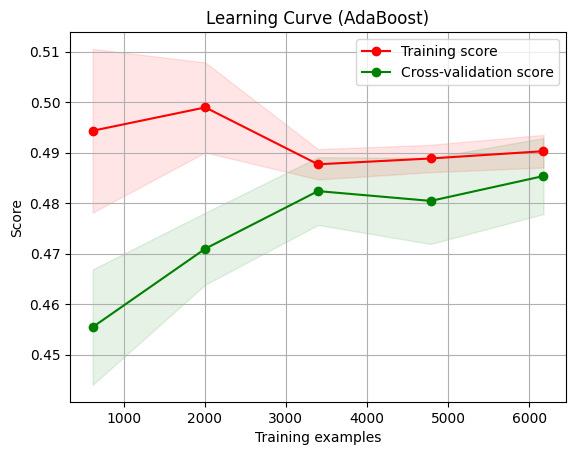

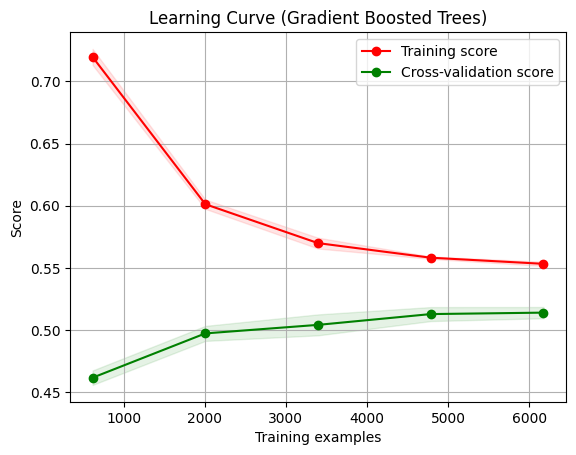

In [ ]:
# Plotting learning curves for final models
plot_learning_curve(final_models['AdaBoost'], "Learning Curve (AdaBoost)", X_train, y_train, cv=5, n_jobs=-1)
plot_learning_curve(final_models['Gradient Boosted Trees'], "Learning Curve (Gradient Boosted Trees)", X_train, y_train, cv=5, n_jobs=-1)

#plt.show()

In [ ]:
# Evaluating each model and find the best one based on test accuracy and cross-validation score
best_model_name = None
best_model = None
best_test_accuracy = 0
best_cv_score_mean = 0

for model_name, model in final_models.items():
    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),  # Retain 95% of the variance
        ('classifier', model)
    ])

    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)

    # Fit the pipeline on the full training data
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    if test_accuracy > best_test_accuracy and mean_cv_score > best_cv_score_mean:
        best_test_accuracy = test_accuracy
        best_cv_score_mean = mean_cv_score
        best_model_name = model_name
        best_model = pipeline

    print(f"Model: {model_name}")
    print(f"Cross-Validation Accuracy: {mean_cv_score:.4f} ± {std_cv_score:.4f}")
    print(f"Test Accuracy: {test_accuracy}")
    print("\n" + "="*60 + "\n")

# Printing the best model
print(f"Best Model: {best_model_name}")
print(f"Best Model Test Accuracy: {best_test_accuracy}")
print(f"Best Model Cross-Validation Accuracy: {best_cv_score_mean:.4f}")

Model: Decision Tree with GridSearchCV
Cross-Validation Accuracy: 0.4872 ± 0.0088
Test Accuracy: 0.3231460674157303


Model: Decision Tree with RandomizedSearchCV
Cross-Validation Accuracy: 0.4873 ± 0.0088
Test Accuracy: 0.3231460674157303


Model: Random Forest
Cross-Validation Accuracy: 0.4655 ± 0.0077
Test Accuracy: 0.30786516853932583


Model: Gradient Boosted Trees
Cross-Validation Accuracy: 0.5074 ± 0.0123
Test Accuracy: 0.3231460674157303


Model: AdaBoost
Cross-Validation Accuracy: 0.4905 ± 0.0051
Test Accuracy: 0.31775280898876407


Model: SVM
Cross-Validation Accuracy: 0.4824 ± 0.0138
Test Accuracy: 0.3155056179775281


Best Model: Decision Tree with GridSearchCV
Best Model Test Accuracy: 0.3231460674157303
Best Model Cross-Validation Accuracy: 0.4872


# Part 5 - t-SNE for classification visualization

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning:

X has feature names, but PCA was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning:

X has feature names, but PCA was fitted without feature names



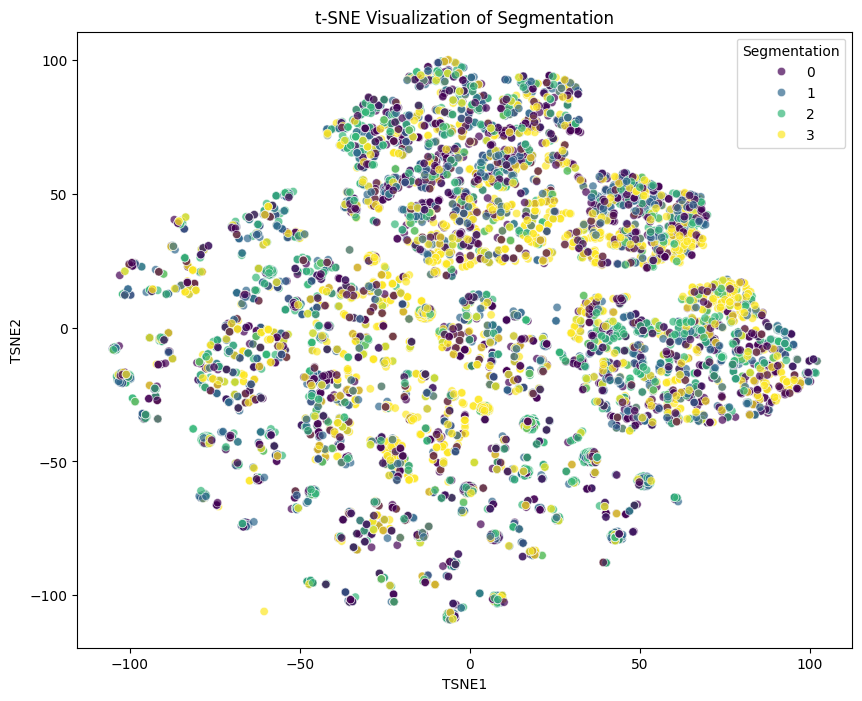

In [ ]:
# t-SNE Visualization for the Best Performing Model

# Assuming best_model is obtained from RandomizedSearchCV
best_model = random_search.best_estimator_

# Fitting the best model pipeline to the training data again if needed
best_model.fit(X_train, y_train)

# Getting the outputs of the PCA step
pca = best_model.named_steps['pca']
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Concatenating the PCA-transformed train and test data
X_combined_pca = np.vstack((X_train_pca, X_test_pca))
y_combined = np.concatenate((y_train, y_test))

# Applying t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_combined_pca)

# Creating a DataFrame for the t-SNE result
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['Segmentation'] = y_combined

# Plotting the t-SNE result
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Segmentation', data=tsne_df, palette='viridis', alpha=0.7)
plt.title('t-SNE Visualization of Segmentation')
plt.show()

### **Part 2: Alternative Segmentation - By Analysis of Train alone, Train Clustering, Test Clustering, Analysis of Alternative Classification**

## Train Dataset Model Evaluation

In [ ]:
# Splitting the dataset
X = df_train.drop(columns=['Segmentation'])
y = df_train['Segmentation']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
# List of classification models to evaluate
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'ExtraTrees': ExtraTreesClassifier(random_state=42),
    'Bagging': BaggingClassifier(random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(random_state=42)
}

In [ ]:
# Model Evaluation
def evaluate_model(model, X_train, y_train, X_val, y_val):
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        cm = confusion_matrix(y_val, y_pred)
        cr = classification_report(y_val, y_pred)
        return accuracy, cm, cr
    except Exception as e:
        print(f"Error evaluating model {model}: {e}")
        return None, None, None

# Evaluate each model and print results
results = {}
for name, model in models.items():
    accuracy, cm, cr = evaluate_model(model, X_train_scaled, y_train, X_val_scaled, y_val)
    if accuracy is not None:
        results[name] = {
            'accuracy': accuracy,
            'confusion_matrix': cm,
            'classification_report': cr
        }

In [ ]:
# Finding the best model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model_accuracy = results[best_model_name]['accuracy']
best_model_cm = results[best_model_name]['confusion_matrix']

print(f'Best Model: {best_model_name}')
print(f'Accuracy: {best_model_accuracy}')
print(f'Confusion Matrix:\n{best_model_cm}')

Best Model: GradientBoosting
Accuracy: 0.5110103626943006
Confusion Matrix:
[[146  81  49  78]
 [ 92 118 103  58]
 [ 41  66 232  51]
 [ 91  32  13 293]]


In [ ]:
# Hyperparameter tuning for improving prediction model performance
# Defining a parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 4],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initializing the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Initializing GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fitting GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Getting the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluating the best model on the validation set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val_scaled)
accuracy = accuracy_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)
cr = classification_report(y_val, y_pred)

print(f'Best Parameters: {best_params}')
print(f'Best Score: {best_score}')
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{cm}')
print(f'Classification Report:\n{cr}')

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best Score: 0.5092299044088598
Accuracy: 0.5116580310880829
Confusion Matrix:
[[143  82  45  84]
 [ 82 121 103  65]
 [ 43  68 227  52]
 [ 88  29  13 299]]
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.40      0.40       354
           1       0.40      0.33      0.36       371
           2       0.59      0.58      0.58       390
           3       0.60      0.70      0.64       429

    accuracy                           0.51      1544
   macro avg       0.50      0.50      0.50      1544
weighted avg       0.50      0.51      0.51      1544



# Part 3: t-SNE Visualization of the Train Data

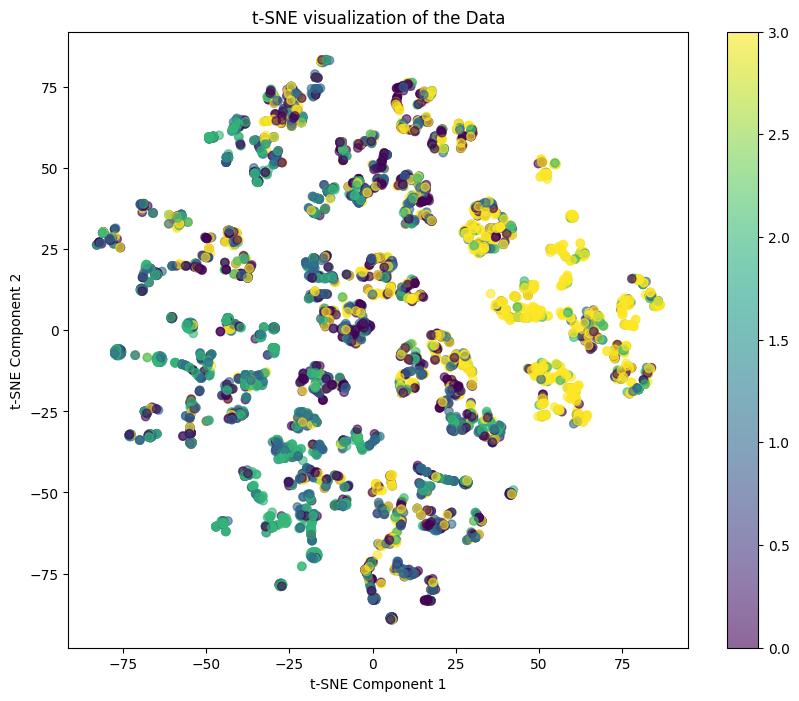

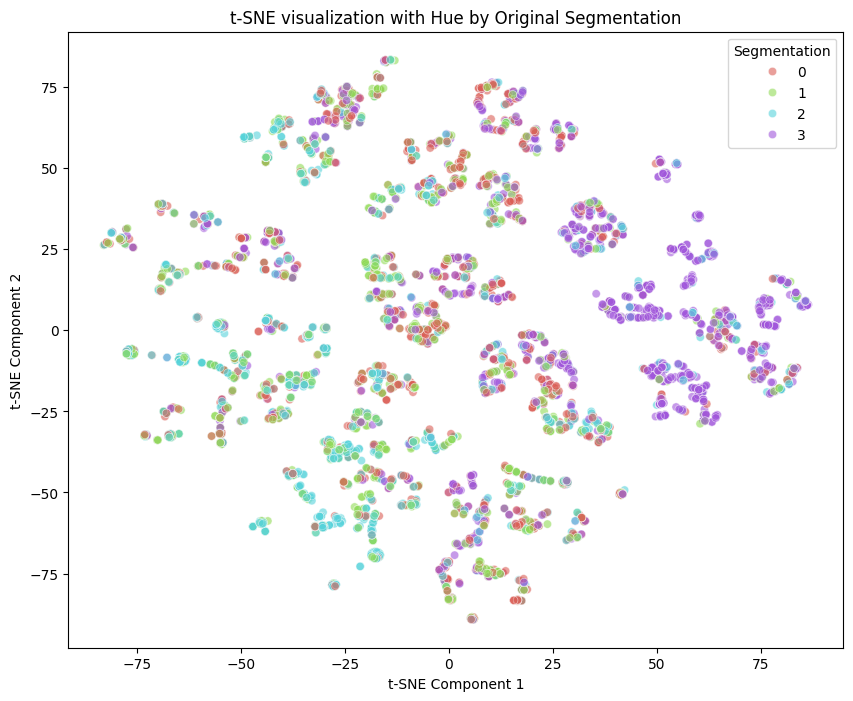

In [ ]:
# t-SNE for Data Visualization
# Converting scaled data back to DataFrame for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled_df['Segmentation'] = y_train.values

# Applying t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X_train_scaled)

# Plotting the t-SNE output
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of the Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter)
plt.show()

plt.figure(figsize=(10,8))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue='Segmentation',
               palette=sns.color_palette('hls', len(y_train.unique())),
               data=X_train_scaled_df,
               alpha=0.6)
plt.title('t-SNE visualization with Hue by Original Segmentation')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Part 4: Train Dataset Clustering

In [ ]:
# Dropping the target variable 'Segmentation' and create a new DataFrame for clustering
df_clustering = df_train.drop(columns=['Segmentation'])

In [ ]:
# Standardizing the data
scaler = StandardScaler()
X_clustering_scaled = scaler.fit_transform(df_clustering)

In [ ]:
# Clustering using K-means and Agglomerative Clustering
# Applying K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_clustering_scaled)

# Applying Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=4)
agg_labels = agg_clustering.fit_predict(X_clustering_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



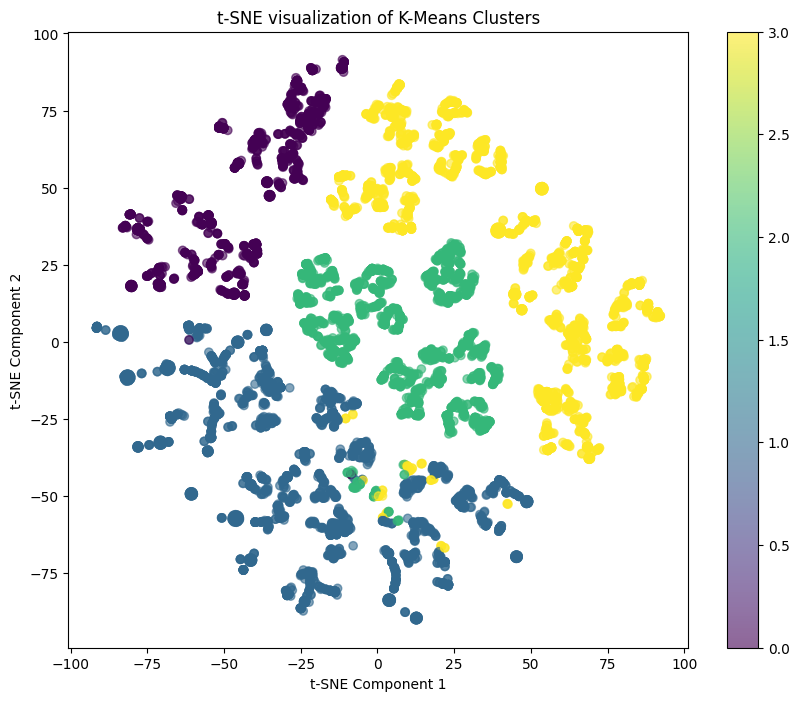

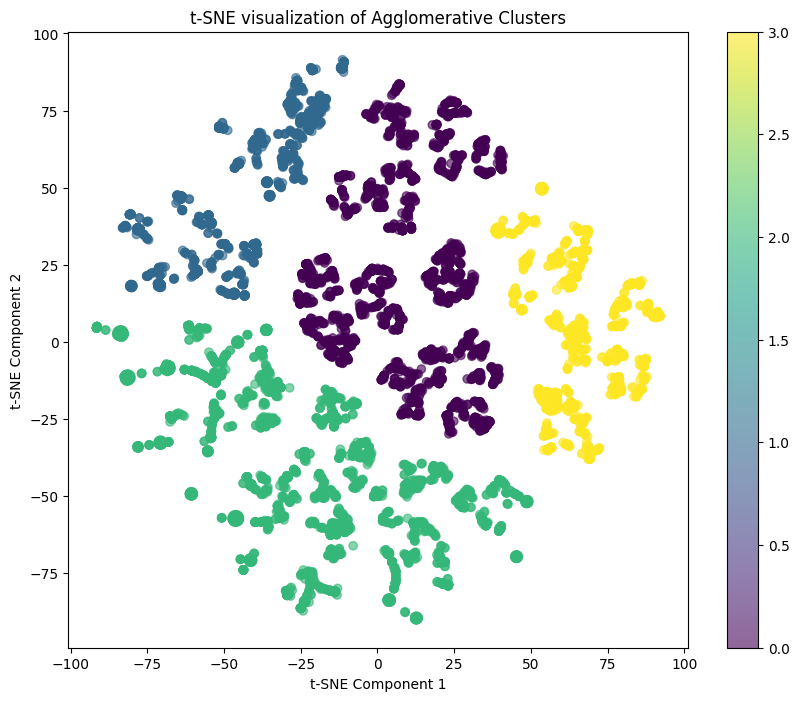

In [ ]:
# t-SNE visualization of K-Means clusters
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_clustering_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of K-Means Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter)
plt.show()

# t-SNE visualization of Agglomerative Clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=agg_labels, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of Agglomerative Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter)
plt.show()

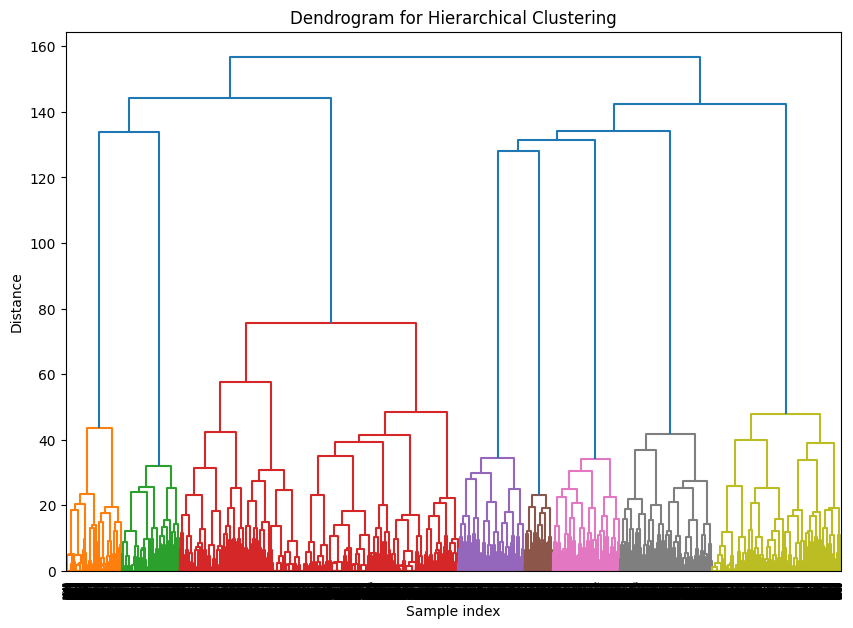

In [ ]:
# Dendrogram for Hierarchical Clustering
linked = linkage(X_clustering_scaled, 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [ ]:
# Silhouette Score for K-Means Clustering
kmeans_labels = kmeans.fit_predict(X_clustering_scaled)
kmeans_silhouette = silhouette_score(X_clustering_scaled, kmeans_labels)
print(f'Silhouette Score for K-Means: {kmeans_silhouette:.4f}')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette Score for K-Means: 0.1886


In [ ]:
# Silhouette Score for Agglomerative Clustering
agg_labels = agg_clustering.fit_predict(X_clustering_scaled)
agg_silhouette = silhouette_score(X_clustering_scaled, agg_labels)
print(f'Silhouette Score for Agglomerative Clustering: {agg_silhouette:.4f}')

Silhouette Score for Agglomerative Clustering: 0.1953


# Part 5: Train Dataset Model Evaluation with New Segmentation

In [ ]:
# Appending the cluster labels to the train dataframe
df_train['KMeans_Cluster'] = kmeans_labels
df_train['Agglomerative_Cluster'] = agg_labels

# Creating the 'Alt_Seg' column based on the clustering results using Agglomerative Clustering
df_train['Alt_Seg'] = agg_labels

print(df_train.head())

   Gender  Ever_Married  Graduated  Work_Experience  Spending_Score  \
0       0             0          0              1.0               1   
1       1             1          1              1.0               2   
2       1             1          1              1.0               1   
3       0             1          1              0.0               3   
4       1             1          1              1.0               3   

   Family_Size  Var_1  Segmentation  Profession_Artist  Profession_Doctor  \
0          4.0      3             3                  0                  0   
1          3.0      3             0                  0                  0   
2          1.0      5             1                  0                  0   
3          2.0      5             1                  0                  0   
4          6.0      5             0                  0                  0   

   Profession_Engineer  Profession_Entertainment  Profession_Executive  \
0                    0              

In [ ]:
# Removing 'Segmentation' and Clustering Columns
df_train = df_train.drop(columns=['KMeans_Cluster', 'Agglomerative_Cluster', 'Segmentation'])

# Defining the new features and target variable
X_alt = df_train.drop(columns=['Alt_Seg'])
y_alt = df_train['Alt_Seg']

# Splitting the data into training and validation sets
X_alt_train, X_alt_val, y_alt_train, y_alt_val = train_test_split(X_alt, y_alt, test_size=0.2, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_alt_train_scaled = scaler.fit_transform(X_alt_train)
X_alt_val_scaled = scaler.transform(X_alt_val)

# Training a model using RandomForestClassifier
alt_model = RandomForestClassifier(random_state=42)
alt_model.fit(X_alt_train_scaled, y_alt_train)

# Predicting the new segmentation on the validation set
y_alt_pred = alt_model.predict(X_alt_val_scaled)

# Evaluating the model
alt_accuracy = accuracy_score(y_alt_val, y_alt_pred)
alt_cm = confusion_matrix(y_alt_val, y_alt_pred)
alt_cr = classification_report(y_alt_val, y_alt_pred)

print(f'Accuracy of the model with Alt_Seg: {alt_accuracy}')
print(f'Confusion Matrix:\n{alt_cm}')
print(f'Classification Report:\n{alt_cr}')

Accuracy of the model with Alt_Seg: 1.0
Confusion Matrix:
[[505   0   0   0]
 [  0 231   0   0]
 [  0   0 555   0]
 [  0   0   0 253]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       505
           1       1.00      1.00      1.00       231
           2       1.00      1.00      1.00       555
           3       1.00      1.00      1.00       253

    accuracy                           1.00      1544
   macro avg       1.00      1.00      1.00      1544
weighted avg       1.00      1.00      1.00      1544



In [ ]:
# Analyzing new classification
# Counting the number of unique classification values
num_classes = df_train['Alt_Seg'].nunique()
print(f'Number of unique classification values: {num_classes}')

# Counting the number of customers in each 'Alt_Seg' type
class_counts = df_train['Alt_Seg'].value_counts()
print(f'Number of customers in each Alt_Seg type:\n{class_counts}')

# Summary statistics for each 'Alt_Seg' type
class_summary = df_train.groupby('Alt_Seg').agg({
    'Work_Experience': ['mean', 'median', 'std'],
    'Family_Size': ['mean', 'median', 'std'],
    'Gender': lambda x: x.value_counts().idxmax(),
    'Ever_Married': lambda x: x.value_counts().idxmax(),
    'Graduated': lambda x: x.value_counts().idxmax(),
    'Spending_Score': lambda x: x.value_counts().idxmax(),
    'Var_1': lambda x: x.value_counts().idxmax(),
})

print(f'Summary statistics for each Alt_Seg type:\n{class_summary}')

Number of unique classification values: 4
Number of customers in each Alt_Seg type:
Alt_Seg
2    2775
0    2528
3    1283
1    1134
Name: count, dtype: int64
Summary statistics for each Alt_Seg type:
        Work_Experience                  Family_Size                   \
                   mean median       std        mean median       std   
Alt_Seg                                                                 
0              2.254351    1.0  2.941283    2.830696    3.0  1.396975   
1              1.579365    1.0  2.383815    2.648148    2.0  1.295866   
2              2.504865    1.0  3.044472    2.503063    2.0  1.277012   
3              2.260327    1.0  2.913074    3.558846    4.0  1.339519   

          Gender Ever_Married Graduated Spending_Score    Var_1  
        <lambda>     <lambda>  <lambda>       <lambda> <lambda>  
Alt_Seg                                                          
0              0            1         1              1        5  
1              0        

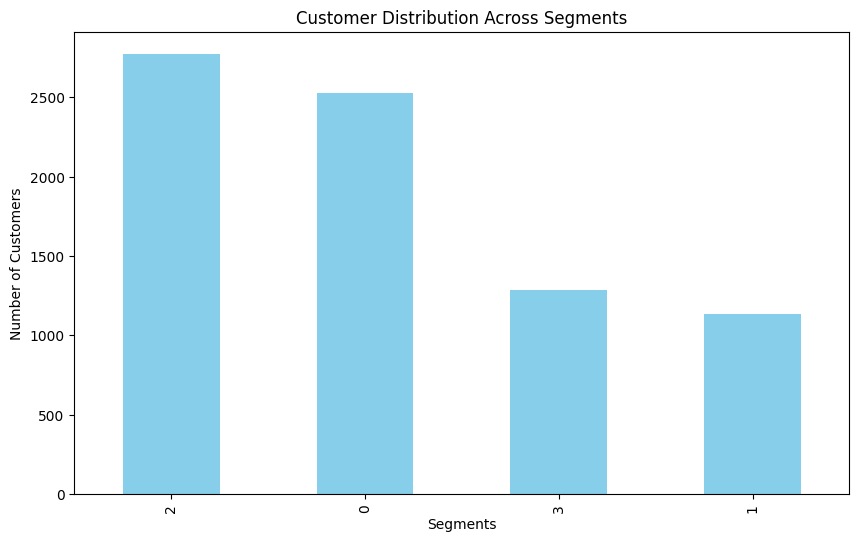

In [ ]:
# Bar plot of customer distribution across segments
plt.figure(figsize=(10, 6))
df_train['Alt_Seg'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Customer Distribution Across Segments')
plt.xlabel('Segments')
plt.ylabel('Number of Customers')
plt.show()

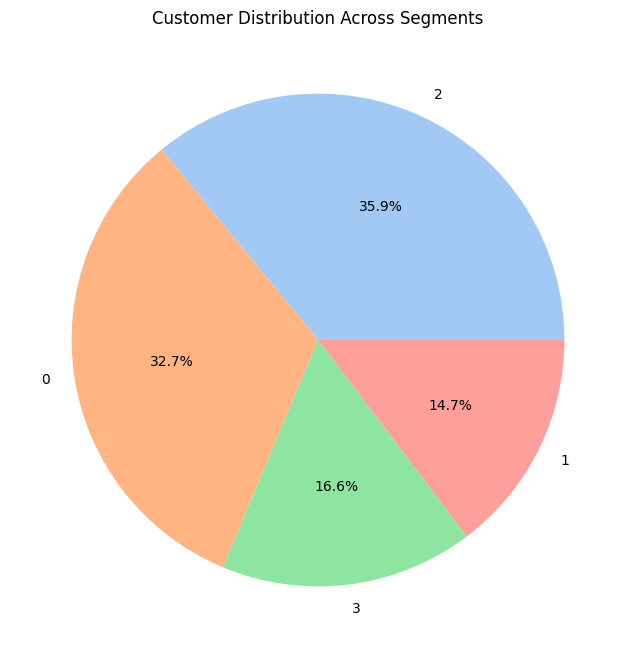

In [ ]:
# Pie chart of customer distribution
plt.figure(figsize=(8, 8))
df_train['Alt_Seg'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Customer Distribution Across Segments')
plt.ylabel('')
plt.show()

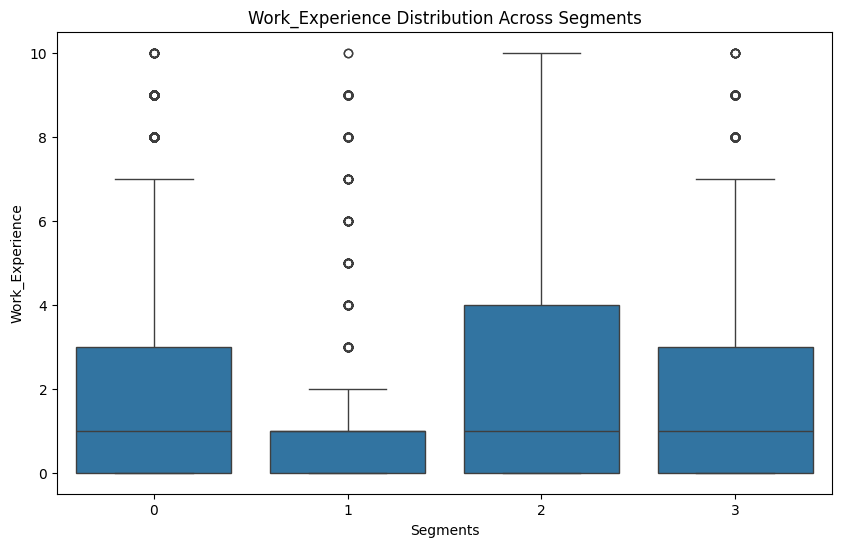

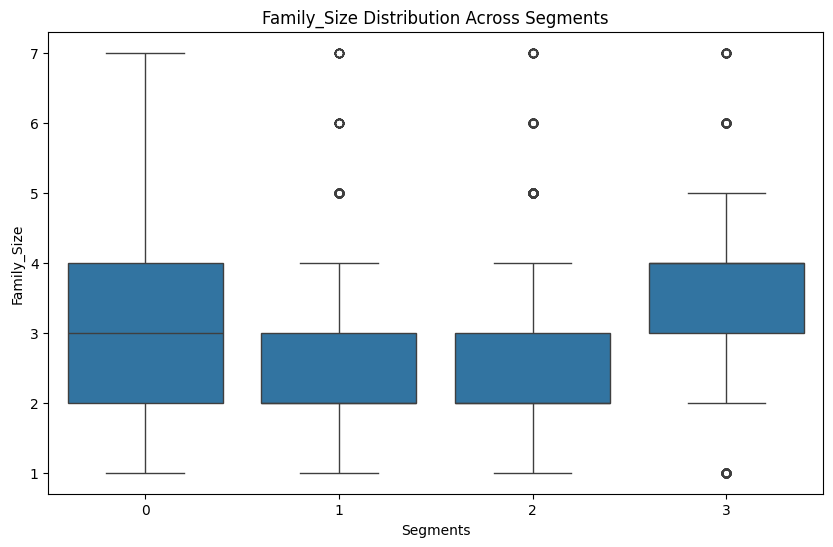

In [ ]:
# Box plots of numerical features across segments
numerical_features = ['Work_Experience', 'Family_Size']
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Alt_Seg', y=feature, data=df_train)
    plt.title(f'{feature} Distribution Across Segments')
    plt.xlabel('Segments')
    plt.ylabel(feature)
    plt.show()

In [ ]:
# Detailed profiles for each segment
for seg in df_train['Alt_Seg'].unique():
    segment_data = df_train[df_train['Alt_Seg'] == seg]
    print(f'\nProfile for Segment {seg}:')
    print(segment_data.describe(include='all'))


Profile for Segment 3:
            Gender  Ever_Married    Graduated  Work_Experience  \
count  1283.000000   1283.000000  1283.000000      1283.000000   
mean      0.419330      0.134061     0.371005         2.260327   
std       0.493642      0.340850     0.483262         2.913074   
min       0.000000      0.000000     0.000000         0.000000   
25%       0.000000      0.000000     0.000000         0.000000   
50%       0.000000      0.000000     0.000000         1.000000   
75%       1.000000      0.000000     1.000000         3.000000   
max       1.000000      1.000000     1.000000        10.000000   

       Spending_Score  Family_Size        Var_1  Profession_Artist  \
count     1283.000000  1283.000000  1283.000000             1283.0   
mean         1.095869     3.558846     3.889322                0.0   
std          0.390216     1.339519     1.565094                0.0   
min          1.000000     1.000000     0.000000                0.0   
25%          1.000000     3.000

<ipython-input-78-10ca5becaeca>:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




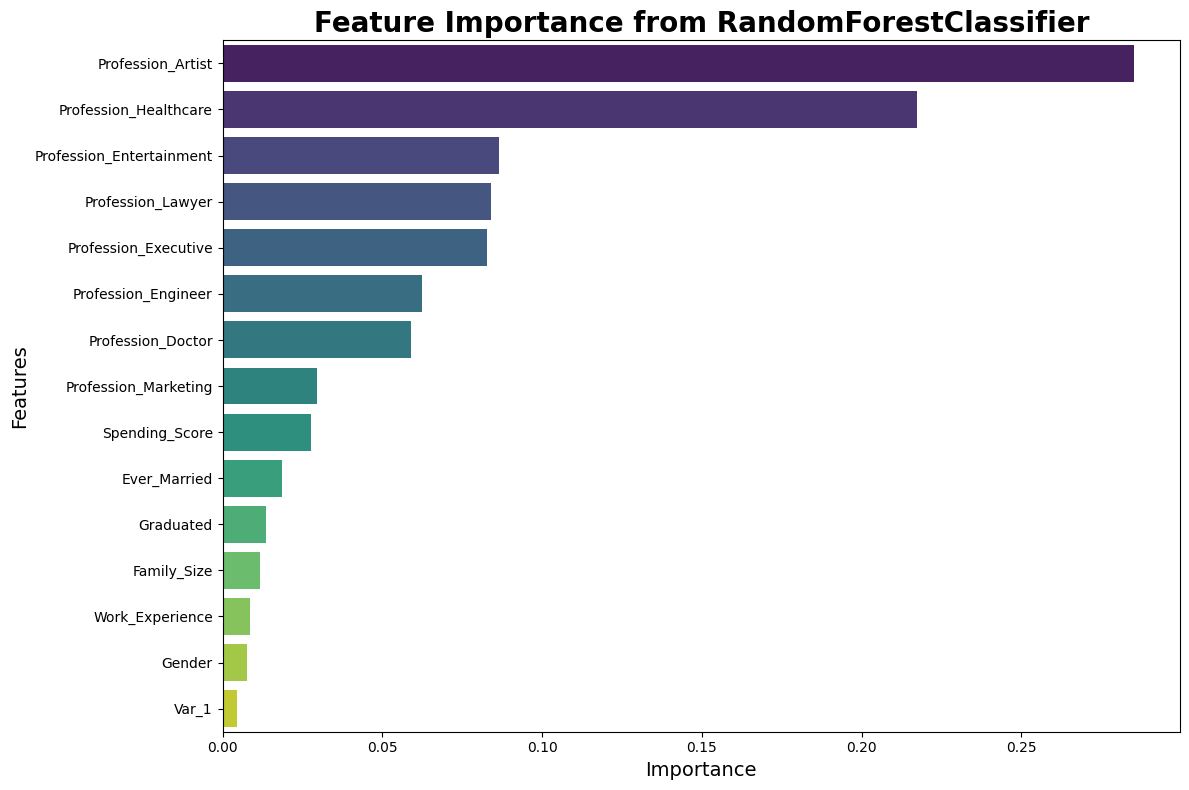

In [ ]:
# Feature importance
feature_importances = alt_model.feature_importances_

# Getting feature names
feature_names = X_alt.columns

# Creating a DataFrame for visualization
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette='viridis')
plt.title('Feature Importance from RandomForestClassifier', fontsize=20, fontweight='bold')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluating prediction models with new segmentation
# Splitting the dataset
X = df_train.drop(columns=['Alt_Seg'])
y = df_train['Alt_Seg']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
# List of models to evaluate
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'ExtraTrees': ExtraTreesClassifier(random_state=42),
    'Bagging': BaggingClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(random_state=42)
}

def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    cr = classification_report(y_val, y_pred)
    return accuracy, cm, cr

# Evaluating each model
results = {}
for name, model in models.items():
    accuracy, cm, cr = evaluate_model(model, X_train_scaled, y_train, X_val_scaled, y_val)
    results[name] = {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': cr
    }

# Finding the best model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model_accuracy = results[best_model_name]['accuracy']
best_model_cm = results[best_model_name]['confusion_matrix']

print(f'Best Model: {best_model_name}')
print(f'Accuracy: {best_model_accuracy}')
print(f'Confusion Matrix:\n{best_model_cm}')

Best Model: RandomForest
Accuracy: 1.0
Confusion Matrix:
[[505   0   0   0]
 [  0 231   0   0]
 [  0   0 555   0]
 [  0   0   0 253]]


# Part 6: Applying Clustering to the Test Dataset

In [ ]:
# Removing 'Segmentation' to apply new clustering on test_df
df_test = df_test.drop(columns=['Segmentation'])

In [ ]:
# Ensuring 'Test' dataset has the same columns as 'Train' dataset
missing_cols = set(X_train.columns) - set(df_test.columns)
for col in missing_cols:
    df_test[col] = 0  # Adding missing columns with default value 0

# Ensuring the same order of columns
df_test = df_test[X_train.columns]

print(df_test.head())

   Gender  Ever_Married  Graduated  Work_Experience  Spending_Score  \
0       1             1          1              0.0               1   
2       1             1          0              0.0               1   
4       1             0          0              1.0               1   
5       0             1          1              0.0               3   
6       0             1          1              5.0               1   

   Family_Size  Var_1  Profession_Artist  Profession_Doctor  \
0          1.0      5                  0                  0   
2          1.0      5                  1                  0   
4          4.0      5                  0                  0   
5          5.0      3                  0                  1   
6          3.0      5                  0                  1   

   Profession_Engineer  Profession_Entertainment  Profession_Executive  \
0                    1                         0                     0   
2                    0                        

In [ ]:
# Standardizing the 'Test' data
X_test_scaled = scaler.transform(df_test)

# Predicting the 'Alt_Seg' on the 'Test' dataset using the best model
y_test_pred = best_model.predict(X_test_scaled)

# Creating a new dataframe with the predictions
df_test['Alt_Seg'] = y_test_pred

# Saving the predictions to a CSV file
df_test.to_csv('Test_with_Alt_Seg.csv', index=False)

print(df_test.head())

   Gender  Ever_Married  Graduated  Work_Experience  Spending_Score  \
0       1             1          1              0.0               1   
2       1             1          0              0.0               1   
4       1             0          0              1.0               1   
5       0             1          1              0.0               3   
6       0             1          1              5.0               1   

   Family_Size  Var_1  Profession_Artist  Profession_Doctor  \
0          1.0      5                  0                  0   
2          1.0      5                  1                  0   
4          4.0      5                  0                  0   
5          5.0      3                  0                  1   
6          3.0      5                  0                  1   

   Profession_Engineer  Profession_Entertainment  Profession_Executive  \
0                    1                         0                     0   
2                    0                        

Count of each predicted Alt_Seg:
Alt_Seg
3    683
2    544
0    526
1    472
Name: count, dtype: int64


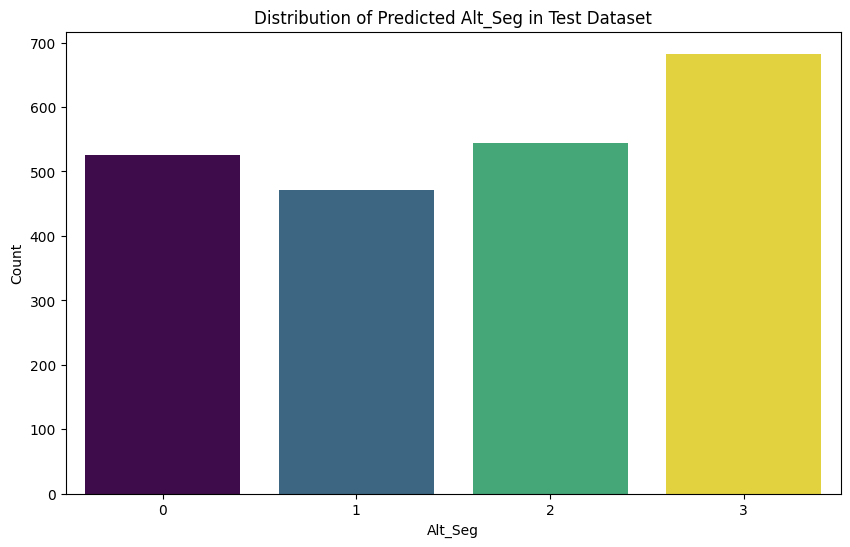

In [ ]:
# Count of each predicted segment
alt_seg_counts = df_test['Alt_Seg'].value_counts()
print("Count of each predicted Alt_Seg:")
print(alt_seg_counts)

# Convert counts to string for title
counts_str = ', '.join([f'Alt_Seg {seg}: {count}' for seg, count in alt_seg_counts.items()])

# Visualizing the distribution of the predicted labels
plt.figure(figsize=(10, 6))
sns.countplot(x='Alt_Seg', data=df_test, palette='viridis', hue='Alt_Seg', dodge=False, legend=False)
plt.title(f'Distribution of Predicted Alt_Seg in Test Dataset')
plt.xlabel('Alt_Seg')
plt.ylabel('Count')
plt.show()


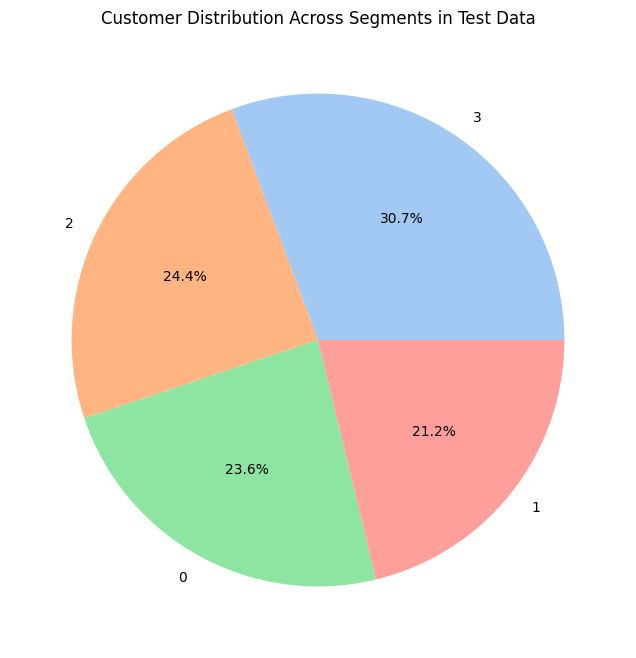

In [ ]:
# Pie chart of customer distribution across segments in test data
plt.figure(figsize=(8, 8))
df_test['Alt_Seg'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Customer Distribution Across Segments in Test Data')
plt.ylabel('')
plt.show()

In [ ]:
# Calculating silhouette score
silhouette_avg = silhouette_score(X_test_scaled, y_test_pred)
print(f'Silhouette Score for the clustering on test data: {silhouette_avg}')

Silhouette Score for the clustering on test data: 0.05711695767803854


In [ ]:
# Getting summary statistics
test_class_summary = df_test.groupby('Alt_Seg').agg({
    'Work_Experience': ['mean', 'median', 'std'],
    'Family_Size': ['mean', 'median', 'std'],
    'Gender': lambda x: x.value_counts().idxmax(),
    'Ever_Married': lambda x: x.value_counts().idxmax(),
    'Graduated': lambda x: x.value_counts().idxmax(),
    'Spending_Score': lambda x: x.value_counts().idxmax(),
    'Var_1': lambda x: x.value_counts().idxmax(),
})

print(f'Summary statistics for each Alt_Seg type in test data:\n{test_class_summary}')

Summary statistics for each Alt_Seg type in test data:
        Work_Experience                  Family_Size                   \
                   mean median       std        mean median       std   
Alt_Seg                                                                 
0              1.488593    1.0  1.812881    2.030418    2.0  1.201200   
1              1.135593    1.0  1.534682    2.586864    2.0  1.364113   
2              1.246324    1.0  1.649260    2.898897    3.0  1.054185   
3              1.366032    1.0  1.788892    3.408492    3.0  1.504164   

          Gender Ever_Married Graduated Spending_Score    Var_1  
        <lambda>     <lambda>  <lambda>       <lambda> <lambda>  
Alt_Seg                                                          
0              1            1         1              1        5  
1              0            1         1              1        5  
2              0            1         1              2        5  
3              0            0        

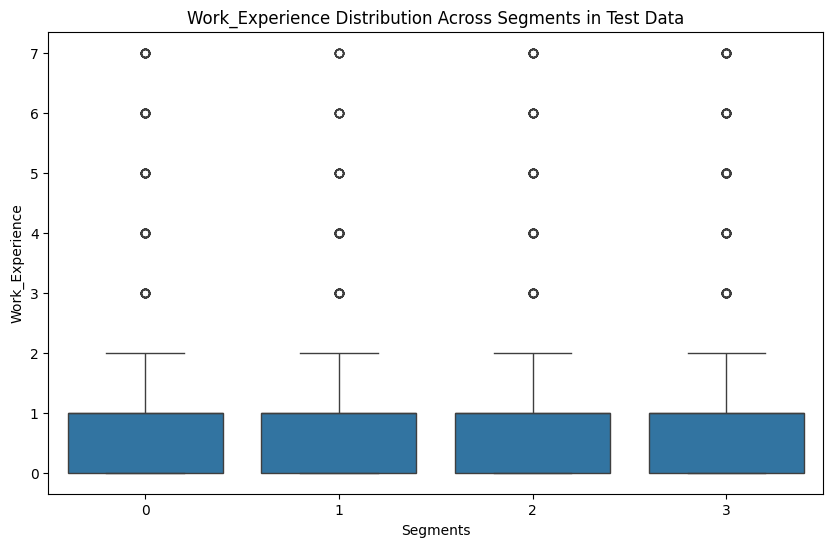

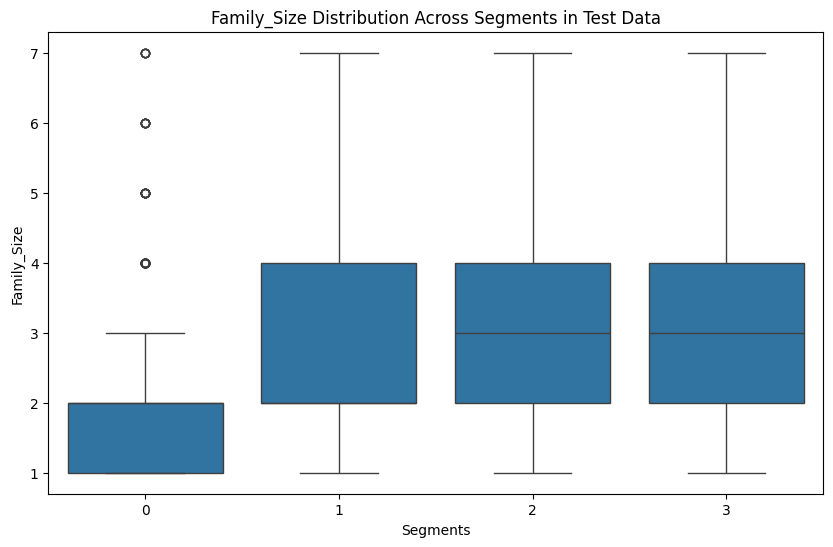

In [ ]:
# Box plots of numerical features in test data, by segment
numerical_features = ['Work_Experience', 'Family_Size']
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Alt_Seg', y=feature, data=df_test)
    plt.title(f'{feature} Distribution Across Segments in Test Data')
    plt.xlabel('Segments')
    plt.ylabel(feature)
    plt.show()


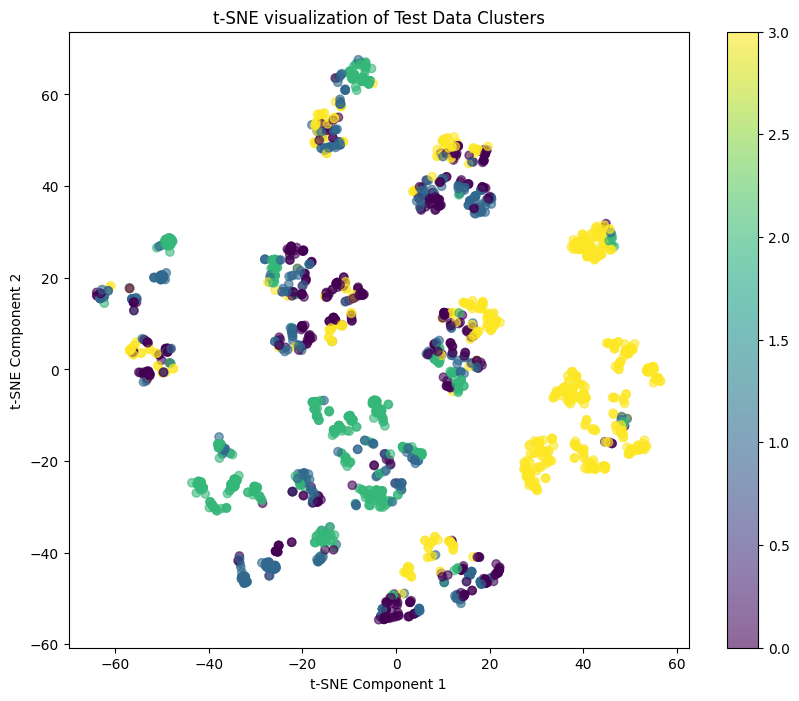

In [ ]:
# t-SNE to the test data
tsne_test = TSNE(n_components=2, random_state=42)
X_tsne_test = tsne_test.fit_transform(X_test_scaled)

# t-SNE visualization of agglomerative clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne_test[:, 0], X_tsne_test[:, 1], c=y_test_pred, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of Test Data Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter)
plt.show()

# Part 7: Evaluating Model on the Test Dataset with the New Segmentation

In [ ]:
# Defining df as train and test_df as test to apply models and see fit of the new classification on test
X_train_1 = df_train.drop(columns=['Alt_Seg'])
y_train_1 = df_train['Alt_Seg']

X_test_1 = df_test.drop(columns=['Alt_Seg'])
y_test_1 = df_test['Alt_Seg']

In [ ]:
# Standardizing the data
scaler_1 = StandardScaler()
X_train_scaled_1 = scaler_1.fit_transform(X_train_1)
X_test_scaled_1 = scaler_1.transform(X_test_1)

In [ ]:
# Training the model
model_1 = GradientBoostingClassifier(random_state=42)
model_1.fit(X_train_scaled_1, y_train_1)

# Predicting on the test set
y_test_pred_1 = model_1.predict(X_test_scaled_1)

# Evaluating the model
accuracy_1 = accuracy_score(y_test_1, y_test_pred_1)
cm_1 = confusion_matrix(y_test_1, y_test_pred_1)
cr_1 = classification_report(y_test_1, y_test_pred_1)

print(f'Accuracy of GradientBoostingClassifier on test data: {accuracy_1}')
print(f'Confusion Matrix:\n{cm_1}')
print(f'Classification Report:\n{cr_1}')

Accuracy of GradientBoostingClassifier on test data: 0.5006741573033708
Confusion Matrix:
[[288  86 147   5]
 [157 109 203   3]
 [ 84  89 369   2]
 [226  68  41 348]]
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.55      0.45       526
           1       0.31      0.23      0.26       472
           2       0.49      0.68      0.57       544
           3       0.97      0.51      0.67       683

    accuracy                           0.50      2225
   macro avg       0.54      0.49      0.49      2225
weighted avg       0.57      0.50      0.51      2225



In [ ]:
# Summary statistics
test_class_summary_1 = df_test.groupby('Alt_Seg').agg({
    'Work_Experience': ['mean', 'median', 'std'],
    'Family_Size': ['mean', 'median', 'std'],
    'Gender': lambda x: x.value_counts().idxmax(),
    'Ever_Married': lambda x: x.value_counts().idxmax(),
    'Graduated': lambda x: x.value_counts().idxmax(),
    'Spending_Score': lambda x: x.value_counts().idxmax(),
    'Var_1': lambda x: x.value_counts().idxmax(),
})
print(f'Summary statistics for each Alt_Seg type in test data:\n{test_class_summary_1}')

Summary statistics for each Alt_Seg type in test data:
        Work_Experience                  Family_Size                   \
                   mean median       std        mean median       std   
Alt_Seg                                                                 
0              1.488593    1.0  1.812881    2.030418    2.0  1.201200   
1              1.135593    1.0  1.534682    2.586864    2.0  1.364113   
2              1.246324    1.0  1.649260    2.898897    3.0  1.054185   
3              1.366032    1.0  1.788892    3.408492    3.0  1.504164   

          Gender Ever_Married Graduated Spending_Score    Var_1  
        <lambda>     <lambda>  <lambda>       <lambda> <lambda>  
Alt_Seg                                                          
0              1            1         1              1        5  
1              0            1         1              1        5  
2              0            1         1              2        5  
3              0            0        